In [188]:
midx = '53'

# pytorch models with folds

mnames = ['iv3_q11','irv2_q10','resnet_q24','resnet_q25','resnet_q40',
          'gap_q12','nas_q11','se_resnext_q26','bni_q0','bni_q1']

mnames += ['iv3_q12','iv3_u11','resnet_q26','resnet_q27',
           'resnet_u25','resnet_u31','resnet_u56','resnet_u101',
           'gap_u14','bni_u1']

# mnames = ['iv3_q11','irv2_q10',
#            'resnet_q24','resnet_q25','resnet_q26','resnet_q27',
#            'resnet_q40',
#            'resnet_u25',
#            'gap_q12','nas_q11','nas_q12',
#            'se_resnext_q26','se_resnext_q28',
#            'bni_q0','bni_q1']

special = 'resnet_u101'

olist = []

gpct = 90.
gscale = 10.
nfold = 4

In [189]:
import numpy as np
import pandas as pd
import pickle
import os
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Reshape, Lambda, Activation
from keras.layers import UpSampling2D, Dropout, BatchNormalization, MaxPooling2D
from keras.losses import binary_crossentropy
from keras import backend as K
from keras.applications import MobileNet

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.morphology import opening, closing

from scipy.special import logit, expit
import scipy.optimize as opt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import gc
import cv2
from tqdm import tqdm_notebook

from sklearn.metrics import jaccard_similarity_score, f1_score, precision_score, recall_score

# from metrics import iou_metric, iou_metric_batch
# from metric import mean_iou

In [190]:
PATH_TO_TRAIN = './train/'
PATH_TO_TEST = './test/'
PATH_TO_TARGET = './train.csv'
PATH_TO_SUB = './sample_submission.csv'

LABEL_MAP = {
0: "Nucleoplasm" ,
1: "Nuclear membrane"   ,
2: "Nucleoli"   ,
3: "Nucleoli fibrillar center",   
4: "Nuclear speckles"   ,
5: "Nuclear bodies"   ,
6: "Endoplasmic reticulum"   ,
7: "Golgi apparatus"  ,
8: "Peroxisomes"   ,
9:  "Endosomes"   ,
10: "Lysosomes"   ,
11: "Intermediate filaments"  , 
12: "Actin filaments"   ,
13: "Focal adhesion sites"  ,
14: "Microtubules"   ,
15: "Microtubule ends"   ,
16: "Cytokinetic bridge"   ,
17: "Mitotic spindle"  ,
18: "Microtubule organizing center",  
19: "Centrosome",
20: "Lipid droplets"   ,
21: "Plasma membrane"  ,
22: "Cell junctions"   ,
23: "Mitochondria"   ,
24: "Aggresome"   ,
25: "Cytosol" ,
26: "Cytoplasmic bodies",
27: "Rods & rings"}

In [191]:
df = pd.read_csv(PATH_TO_TARGET)
df.set_index('Id',inplace=True)
print(df.head())
print(df.shape)

                                       Target
Id                                           
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18
(31072, 1)


In [192]:
file_list = list(df.index.values)

ss = pd.read_csv(PATH_TO_SUB)
ss.set_index('Id',inplace=True)
print(ss.head())
print(ss.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [193]:
# train_df["images"] = [np.array(load_img("images/{}.png".format(idx), color_mode = "grayscale")) / 255 \
#                       for idx in tqdm_notebook(train_df.index)]

# train_df["masks"] = [np.array(load_img("masks/{}.png".format(idx), color_mode = "grayscale")) / 255 \
#                      for idx in tqdm_notebook(train_df.index)]

In [194]:
df.columns

Index(['Target'], dtype='object')

In [195]:
# estimate thresholds by line search
def F1_hard(preds, targs, th=0.5):
    return -f1_score(targs,  (preds>th).astype(int))

def fit_val1(x, y, start=0.5):
    params = np.array([start])
    wd = 1e-5
#     error = lambda p: np.array(F1_hard(x,y,p), wd*(p - 0.5))
    error = lambda p: np.array(F1_hard(x,y,p))
    p = opt.minimize_scalar(error, bounds=[0.3,0.7], method='bounded').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='brent').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='golden').x
    return p

In [196]:
oof = df.copy()
# print(oof.head())
# print(oof.shape)
eps = 1e-6
num_classes = 28
np.set_printoptions(precision=3,linewidth=80,suppress=True)

for k,m in enumerate(mnames):
    print(' ')
    print(m)
    first = True
    for fold in range(nfold):
        idf, pooff, yooff = pickle.load(open('oof/'+m+'_'+str(fold)+'.pkl','rb'))
        
        # change to probability scale
        # reduce map to single number
        if m in olist: 
            pooff = expit(pooff)
        else: 
            pooff = np.percentile(pooff, gpct, axis=(2,3))
            pooff = 1./(1. + np.exp(-pooff/gscale))
            
        if first:
            id = idf
            poof = pooff.copy()
            yoof = yooff.copy()
            first = False
        else:
            id = id + idf
            poof = np.concatenate((poof,pooff))
            yoof = np.concatenate((yoof,yooff))
    
#     # determine class-specific thresholds and convert predictions to binary
#     th = np.zeros(num_classes)
#     for i in range(num_classes):
#         th[i] = fit_val1(poof[:,i],yoof[:,i])
#     print('Thresholds: ',th)
#     poof = poof > th
#     print('F1 macro: ',f1_score(yoof, poof, average='macro'))

    mdf = pd.DataFrame({'Id':id})
    # print(poof.shape)
    if k==0: mdf['y'] = [yoof[i] for i in range(yoof.shape[0])]
    mdf[m] = [poof[i] for i in range(poof.shape[0])]
    mdf.set_index('Id',inplace=True)
    oof = oof.join(mdf)

 
iv3_q11
 
irv2_q10
 
resnet_q24
 
resnet_q25
 
resnet_q40
 
gap_q12
 
nas_q11
 
se_resnext_q26
 
bni_q0
 
bni_q1
 
iv3_q12
 
iv3_u11
 
resnet_q26
 
resnet_q27
 
resnet_u25
 
resnet_u31
 
resnet_u56
 
resnet_u101
 
gap_u14
 
bni_u1


In [197]:
# print(oof.head())
print(oof.shape)

(31072, 22)


In [198]:
oof.columns

Index(['Target', 'y', 'iv3_q11', 'irv2_q10', 'resnet_q24', 'resnet_q25',
       'resnet_q40', 'gap_q12', 'nas_q11', 'se_resnext_q26', 'bni_q0',
       'bni_q1', 'iv3_q12', 'iv3_u11', 'resnet_q26', 'resnet_q27',
       'resnet_u25', 'resnet_u31', 'resnet_u56', 'resnet_u101', 'gap_u14',
       'bni_u1'],
      dtype='object')

In [199]:
vp = oof.loc[oof['y'].notnull()]
print(vp.shape)

(31072, 22)


In [200]:
# # compute rank transform separately for every column
# from scipy.stats import rankdata
# n = vp.shape[0] * 28
# for m in mnames:
#     a = rankdata(np.array(list(vp[m])).flatten()).reshape((vp.shape[0],28))/n
#     vp[m] = [i for i in a]
# print(vp.shape)

In [201]:
vp.head()

Target  \
Id                                              
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18   

                                                                                      y  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                                iv3_q11  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.6349612911071786, 0.3335005806696897, 0.415...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.5398508787714067, 0.7151756958335682, 0.450...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.5963852726886236, 0.36781641616587707, 0.49...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.5399356774238568, 0.6818624411912063, 0.434...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.5191876269250988, 0.41060182930770617, 0.48...   

                                                                               irv2_q10  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.5344023112863627, 0.33976740976571396, 0.44...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.5383846662539561, 0.5707782011700546, 0.510...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.5418327576812514, 0.36512268906905015, 0.48...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.5223155595917686, 0.571533169733108, 0.3854...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.49681146183175534, 0.39463813206025294, 0.4...   

                                                                             resnet_q24  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.5462745900848558, 0.3490719241389025, 0.471...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.5112971555397656, 0.5753917069594046, 0.472...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.5310493318135783, 0.340147084097598, 0.4858...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.5130285090051543, 0.5849133683591821, 0.388...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.4950374388856521, 0.36853584061976824, 0.48...   

                                                                             resnet_q25  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.5476780995164268, 0.3415807138523649, 0.460...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.5029610384545147, 0.5574916385428522, 0.452...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.528092394672466, 0.35272254334729614, 0.469...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.5277645506409527, 0.5646834277453082, 0.361...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.5086226191547994, 0.3650864454984731, 0.444...   

                                                                             resnet_q40  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.548971323902085, 0.3950417678318714, 0.4471...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.5187967865947322, 0.580001929360135, 0.4498...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.5226366374559694, 0.3626791456192704, 0.475...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.523658207

In [202]:
offset = 2
nm = vp.shape[1] - offset
print(offset, nm)

2 20


In [203]:
y = np.array([a for a in vp.y])
y.shape

(31072, 28)

In [204]:
ys = np.sum(y,axis=1)
print(ys.shape)
print(ys.min(),ys.mean(),ys.max())

(31072,)
1.0 1.6343331 5.0


In [205]:
c_val = np.sum(y,axis=0)
for k,v in LABEL_MAP.items():
    print(k,v, 'count', c_val[k],
             'prop', '%6.4f' % (c_val[k]/y.shape[0]))

0 Nucleoplasm count 12885.0 prop 0.4147
1 Nuclear membrane count 1254.0 prop 0.0404
2 Nucleoli count 3621.0 prop 0.1165
3 Nucleoli fibrillar center count 1561.0 prop 0.0502
4 Nuclear speckles count 1858.0 prop 0.0598
5 Nuclear bodies count 2513.0 prop 0.0809
6 Endoplasmic reticulum count 1008.0 prop 0.0324
7 Golgi apparatus count 2822.0 prop 0.0908
8 Peroxisomes count 53.0 prop 0.0017
9 Endosomes count 45.0 prop 0.0014
10 Lysosomes count 28.0 prop 0.0009
11 Intermediate filaments count 1093.0 prop 0.0352
12 Actin filaments count 688.0 prop 0.0221
13 Focal adhesion sites count 537.0 prop 0.0173
14 Microtubules count 1066.0 prop 0.0343
15 Microtubule ends count 21.0 prop 0.0007
16 Cytokinetic bridge count 530.0 prop 0.0171
17 Mitotic spindle count 210.0 prop 0.0068
18 Microtubule organizing center count 902.0 prop 0.0290
19 Centrosome count 1482.0 prop 0.0477
20 Lipid droplets count 172.0 prop 0.0055
21 Plasma membrane count 3777.0 prop 0.1216
22 Cell junctions count 802.0 prop 0.0258
23

In [206]:
# idx = range(28)
# loc = [LABEL_MAP[j] for j in idx]
# lb = [c_val[j]/y.shape[0] for j in idx]

# df = pd.DataFrame({'idx':idx, 'loc':loc, 'training':lb})
# fname = 'train_props.csv'
# df.to_csv(fname,index=False)
# print(fname)

In [207]:
# train_sum_vec = np.sum(np.stack(subm['target_vec'].values, 0), 0)
# _ = plt.bar(n_keys, [train_sum_vec[k] for k in n_keys])

In [208]:
ymean = np.mean(y,axis=0)
print(ymean)

[0.415 0.04  0.117 0.05  0.06  0.081 0.032 0.091 0.002 0.001 0.001 0.035 0.022
 0.017 0.034 0.001 0.017 0.007 0.029 0.048 0.006 0.122 0.026 0.095 0.01  0.265
 0.011 0.   ]


(-0.03034705803458428, 0.4436122904074585)

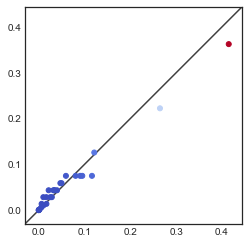

In [209]:
# plot training class frequencies versus those from leaderboard probing by iafoss
lb_prob = np.array([
0.36239782, 0.043841336, 0.075268817, 0.059322034, 0.075268817,
0.075268817, 0.043841336, 0.075268817, 0.0018, 0.0014,
0.0009, 0.043841336, 0.043841336, 0.014198783, 0.043841336,
0.0007, 0.028806584, 0.014198783, 0.028806584, 0.059322034,
0.0056, 0.126126126, 0.028806584, 0.075268817, 0.0104,
0.222493888, 0.028806584, 0.0004
])
   
# sns.regplot(ymean, lb_prob)

c = ymean**2 + lb_prob**2

fig, ax = plt.subplots()
ax.scatter(ymean, lb_prob, s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
# fig.savefig('/Users/paul/Desktop/so.png', dpi=300)

In [210]:
# lb probing resuluts from iafoss
# print lower and upper bound on frequencies
probe = {
0 : 0.019,
1 : 0.003,
2 : 0.005,
3 : 0.004,
4 : 0.005,
5 : 0.005,
6 : 0.003,
7 : 0.005,
8 : 0.000,
9 : 0.000,
10 : 0.000,
11 : 0.003,
12 : 0.003,
13 : 0.001,
14 : 0.003,
15 : 0.000,
16 : 0.002,
17 : 0.001,
18 : 0.002,
19 : 0.004,
20 : 0.000,
21 : 0.008,
22 : 0.002,
23 : 0.005,
24 : 0.000,
25 : 0.013,
26 : 0.002,
27 : 0.000
}

r = 0.000499
for k in range(28):

    # si = 0.019*28
    si = probe[k]*28
    fi = si/(2-si)
    si0 = max(0,(probe[k] - r)*28)
    fi0 = si0/(2-si0)
    si1 = (probe[k] + r)*28
    fi1 = si1/(2-si1)
    print(k,'%6.4f %6.4f %6.4f' % (fi0,fi,fi1),LABEL_MAP[k])

0 0.3496 0.3624 0.3755 Nucleoplasm
1 0.0363 0.0438 0.0515 Nuclear membrane
2 0.0673 0.0753 0.0834 Nucleoli
3 0.0515 0.0593 0.0672 Nucleoli fibrillar center
4 0.0673 0.0753 0.0834 Nuclear speckles
5 0.0673 0.0753 0.0834 Nuclear bodies
6 0.0363 0.0438 0.0515 Endoplasmic reticulum
7 0.0673 0.0753 0.0834 Golgi apparatus
8 0.0000 0.0000 0.0070 Peroxisomes
9 0.0000 0.0000 0.0070 Endosomes
10 0.0000 0.0000 0.0070 Lysosomes
11 0.0363 0.0438 0.0515 Intermediate filaments
12 0.0363 0.0438 0.0515 Actin filaments
13 0.0071 0.0142 0.0214 Focal adhesion sites
14 0.0363 0.0438 0.0515 Microtubules
15 0.0000 0.0000 0.0070 Microtubule ends
16 0.0215 0.0288 0.0363 Cytokinetic bridge
17 0.0071 0.0142 0.0214 Mitotic spindle
18 0.0215 0.0288 0.0363 Microtubule organizing center
19 0.0515 0.0593 0.0672 Centrosome
20 0.0000 0.0000 0.0070 Lipid droplets
21 0.1173 0.1261 0.1351 Plasma membrane
22 0.0215 0.0288 0.0363 Cell junctions
23 0.0673 0.0753 0.0834 Mitochondria
24 0.0000 0.0000 0.0070 Aggresome
25 0.2121

In [211]:
w = 1.0/np.mean(y,axis=0)
np.set_printoptions(precision=4,linewidth=80,suppress=True)
print(w)
print(w/sum(w))

[   2.4115   24.7783    8.5811   19.9052   16.7234   12.3645   30.8254
   11.0106  586.2642  690.4889 1109.7142   28.4282   45.1628   57.8622
   29.1482 1479.6191   58.6264  147.9619   34.4479   20.9663  180.6512
    8.2266   38.7431   10.4796   96.4969    3.7764   94.7317 2824.727 ]
[0.0003 0.0032 0.0011 0.0026 0.0022 0.0016 0.004  0.0014 0.0764 0.09   0.1446
 0.0037 0.0059 0.0075 0.0038 0.1928 0.0076 0.0193 0.0045 0.0027 0.0235 0.0011
 0.005  0.0014 0.0126 0.0005 0.0123 0.3681]


In [212]:
wc = np.clip(w,0.,1000.)
print(wc)
print(wc/sum(wc))

[   2.4115   24.7783    8.5811   19.9052   16.7234   12.3645   30.8254
   11.0106  586.2642  690.4889 1000.       28.4282   45.1628   57.8622
   29.1482 1000.       58.6264  147.9619   34.4479   20.9663  180.6512
    8.2266   38.7431   10.4796   96.4969    3.7764   94.7317 1000.    ]
[0.0005 0.0047 0.0016 0.0038 0.0032 0.0024 0.0059 0.0021 0.1115 0.1313 0.1901
 0.0054 0.0086 0.011  0.0055 0.1901 0.0111 0.0281 0.0066 0.004  0.0344 0.0016
 0.0074 0.002  0.0183 0.0007 0.018  0.1901]


In [213]:
# results for single model designated as special
x = np.array([x for x in vp[special]])
x = np.clip(x,-20,20)
print(x.shape, x.min(), x.mean(), x.max())

(31072, 28) 0.09722344643957725 0.3983835808941189 0.7651189799628599


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


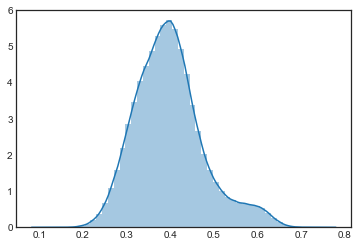

In [214]:
sns.distplot(x.flatten())

In [215]:
# t = -0.12
t = 0.5
xp = np.int32(x > t)
xps = np.sum(xp,axis=1)
print(xps.shape)
print(xps.min(),xps.mean(),xps.max())

(31072,)
0 2.852890061791967 8


In [216]:
print(np.mean(xp,axis=0))

[0.6276 0.0601 0.1602 0.0869 0.093  0.1501 0.0829 0.1263 0.0019 0.0016 0.0011
 0.0593 0.0481 0.0378 0.0495 0.0007 0.0621 0.024  0.0944 0.1042 0.01   0.1929
 0.0566 0.1385 0.0179 0.5332 0.0315 0.0008]


In [217]:
# proportion of zero predictions
print(sum(xps==0)/x.shape[0])

0.00035401647785787845


In [218]:
f1_score(y, xp, average='macro')

0.586642591055005

In [219]:
# make sure every image has at least one prediction
x1 = x.copy()
for i in range(x.shape[0]):
    x1[i,np.argmax(x[i])] = 30

In [220]:
t = 0.6
x1p = np.int32(x1 > t)
x1ps = np.sum(x1p,axis=1)
print(x1ps.shape)
print(x1ps.min(),x1ps.mean(),x1ps.max())

# proportion of zero predictions
print(sum(x1ps==0)/x1.shape[0])

f1_score(y, x1p, average='macro')

(31072,)
1 1.069387229660144 4
0.0


0.598828599574593

In [221]:
# custom thresholds to match observed proportions
thresholds = np.linspace(1.0, 0.0, 1001)
pred = x.copy()
for j in range(pred.shape[1]):
    for t in thresholds:
        pred[:,j] = (x[:,j] > t).astype(int)
        prop = np.mean(pred[:,j])
        if prop >= ymean[j]: break
    print(j,'%6.4f' % t,'%6.4f' % ymean[j],'%6.4f' % prop, LABEL_MAP[j])
print(f1_score(y, pred, average='macro'))

0 0.5570 0.4147 0.4153 Nucleoplasm
1 0.5490 0.0404 0.0406 Nuclear membrane
2 0.5300 0.1165 0.1171 Nucleoli
3 0.5360 0.0502 0.0505 Nucleoli fibrillar center
4 0.5410 0.0598 0.0604 Nuclear speckles
5 0.5240 0.0809 0.0825 Nuclear bodies
6 0.5530 0.0324 0.0331 Endoplasmic reticulum
7 0.5270 0.0908 0.0912 Golgi apparatus
8 0.5130 0.0017 0.0017 Peroxisomes
9 0.5110 0.0014 0.0014 Endosomes
10 0.5210 0.0009 0.0009 Lysosomes
11 0.5390 0.0352 0.0353 Intermediate filaments
12 0.5510 0.0221 0.0225 Actin filaments
13 0.5460 0.0173 0.0175 Focal adhesion sites
14 0.5600 0.0343 0.0343 Microtubules
15 0.5020 0.0007 0.0007 Microtubule ends
16 0.5450 0.0171 0.0173 Cytokinetic bridge
17 0.5670 0.0068 0.0068 Mitotic spindle
18 0.5500 0.0290 0.0297 Microtubule organizing center
19 0.5320 0.0477 0.0488 Centrosome
20 0.5350 0.0055 0.0057 Lipid droplets
21 0.5260 0.1216 0.1226 Plasma membrane
22 0.5520 0.0258 0.0259 Cell junctions
23 0.5390 0.0954 0.0960 Mitochondria
24 0.5620 0.0104 0.0104 Aggresome
25 0.5490

In [222]:
# estimate thresholds by least squares, from iafoss kernel
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.95*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params, maxfev=10000)
    return p

In [223]:
# #  pred = sigmoid_np(x)
# pred = x
# print(pred.min(),pred.mean(),pred.max())
# name_label_dict = LABEL_MAP
# th = fit_val(pred,y)
# # th[th<0.1] = 0.1
# print('Thresholds: ',th)
# print('F1 macro: ',f1_score(y, pred>th, average='macro'))
# # print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
# print('F1 micro: ',f1_score(y, pred>th, average='micro'))

In [224]:
pred = x
num_classes = x.shape[1]
print(pred.min(),pred.mean(),pred.max(),num_classes)
name_label_dict = LABEL_MAP
th = np.zeros(num_classes)
for i in range(num_classes):
    th[i] = fit_val1(pred[:,i],y[:,i])
# th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

0.09722344643957725 0.3983835808941189 0.7651189799628599 28
Thresholds:  [0.5463 0.5472 0.5334 0.54   0.5426 0.5367 0.5538 0.5423 0.5472 0.5168 0.5228
 0.5527 0.5503 0.5498 0.5561 0.5299 0.5674 0.5753 0.5472 0.5292 0.5472 0.5167
 0.5525 0.5479 0.5491 0.5366 0.5683 0.5472]
F1 macro:  0.681224540300976
F1 micro:  0.727528520021438


In [225]:
# estimate thresholds by line search on observed proportions
def prop_mse(preds, targs, th=0.5):
    pm = np.mean((preds>th))
    tm = np.mean(targs)
#     print(th,pm,tm)
    return (tm - pm)**2
#     return (np.mean(targs) - np.mean((preds>th)))**2

def fit_val2(x, y, start=0.54):
    params = np.array([start])
    wd = 1e-5
#     error = lambda p: np.array(F1_hard(x,y,p), wd*(p - 0.5))
    error = lambda p: np.array(prop_mse(x,y,p))
#     p = opt.minimize_scalar(error, bounds=[0.,1.0], method='bounded').x
    p = opt.minimize_scalar(error, bounds=[0.4,0.6], method='bounded').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='brent').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='golden').x
    return p

In [226]:
# prop_mse(pred[:,0],y[:,0], 0.618)

In [227]:
# fit_val2(pred[:,0],y[:,0])

In [228]:
pred = x
num_classes = x.shape[1]
print(pred.min(),pred.mean(),pred.max(),num_classes)
name_label_dict = LABEL_MAP
th = np.zeros(num_classes)
for i in range(num_classes):
    th[i] = fit_val2(pred[:,i],y[:,i])
# th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

0.09722344643957725 0.3983835808941189 0.7651189799628599 28
Thresholds:  [0.5572 0.5496 0.5306 0.5361 0.542  0.5248 0.5538 0.5274 0.5166 0.5108 0.5219
 0.5393 0.5521 0.5467 0.5595 0.4892 0.5454 0.5675 0.5506 0.5329 0.5361 0.5265
 0.5522 0.5395 0.5611 0.55   0.5546 0.5401]
F1 macro:  0.6700017366108348
F1 micro:  0.7211475038640637


In [229]:
np.mean(pred[:,0] > 0.618)

0.0873133367662204

In [230]:
# model- and class-specific thresholds 
# compute best threshold to maximize f1 score by grid search

thresholds = np.linspace(0, 1.0, 101)

fm = [[f1_score(y[:,j], (x[:,j] > t).astype(int)) \
       for t in thresholds] for j in range(y.shape[1])]

besti = [np.argmax(f) for f in fm]
bestt = [thresholds[b] for b in besti]
bests = [f[b] for f,b in zip(fm,besti)]

# td = {}
# print(special)
# for j in range(y.shape[1]):
#     # print(j, "%4.2f" % bestt[j], "%6.4f" % bests[j], LABEL_MAP[j])
    
#     plt.plot(thresholds, fm[j])
#     plt.plot(bestt[j], bests[j], "xr", label="best")
#     plt.xlabel("threshold")
#     plt.ylabel("f1")
#     plt.title(LABEL_MAP[j] + " f1 vs threshold (%6.4f, %6.4f)" % (bestt[j], bests[j]))
#     plt.legend()
#     plt.show()
#     plt.gcf().clear()
 
print(special)
for j in range(y.shape[1]):
    print(j, "%5.3f" % bestt[j], "%6.4f" % bests[j], LABEL_MAP[j])
    
print(np.mean(bests))   

resnet_u101
0 0.550 0.8222 Nucleoplasm
1 0.550 0.8327 Nuclear membrane
2 0.530 0.7765 Nucleoli
3 0.540 0.7195 Nucleoli fibrillar center
4 0.540 0.7464 Nuclear speckles
5 0.540 0.6043 Nuclear bodies
6 0.550 0.5883 Endoplasmic reticulum
7 0.530 0.7908 Golgi apparatus
8 0.530 0.9200 Peroxisomes
9 0.510 0.8352 Endosomes
10 0.520 0.9123 Lysosomes
11 0.550 0.7495 Intermediate filaments
12 0.560 0.6794 Actin filaments
13 0.560 0.6781 Focal adhesion sites
14 0.570 0.8599 Microtubules
15 0.530 0.6286 Microtubule ends
16 0.560 0.4435 Cytokinetic bridge
17 0.570 0.3512 Mitotic spindle
18 0.550 0.4770 Microtubule organizing center
19 0.530 0.5825 Centrosome
20 0.550 0.5890 Lipid droplets
21 0.530 0.6503 Plasma membrane
22 0.560 0.6097 Cell junctions
23 0.550 0.7909 Mitochondria
24 0.550 0.6794 Aggresome
25 0.540 0.6707 Cytosol
26 0.570 0.4839 Cytoplasmic bodies
27 0.520 0.5926 Rods & rings
0.6808701634367066


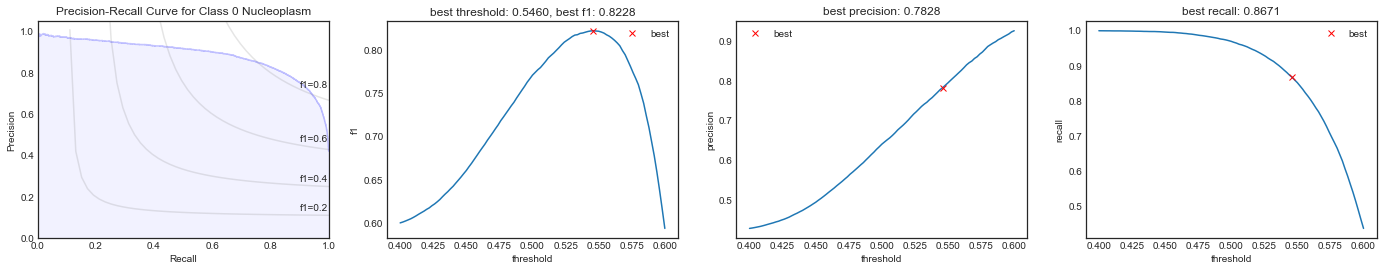

<Figure size 432x288 with 0 Axes>

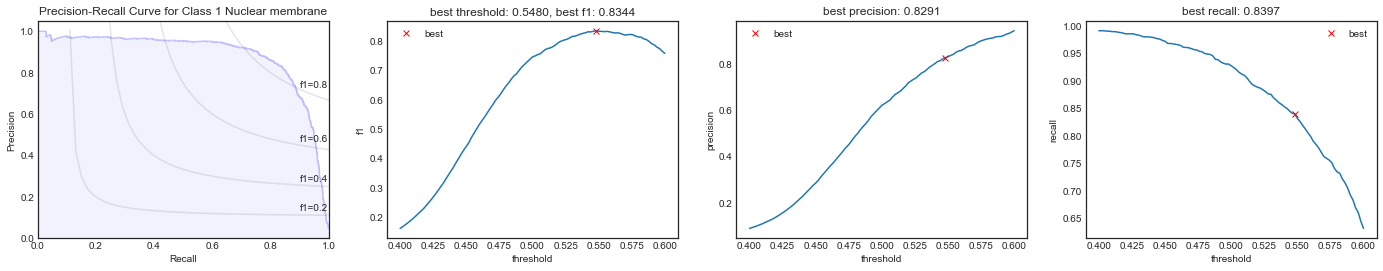

<Figure size 432x288 with 0 Axes>

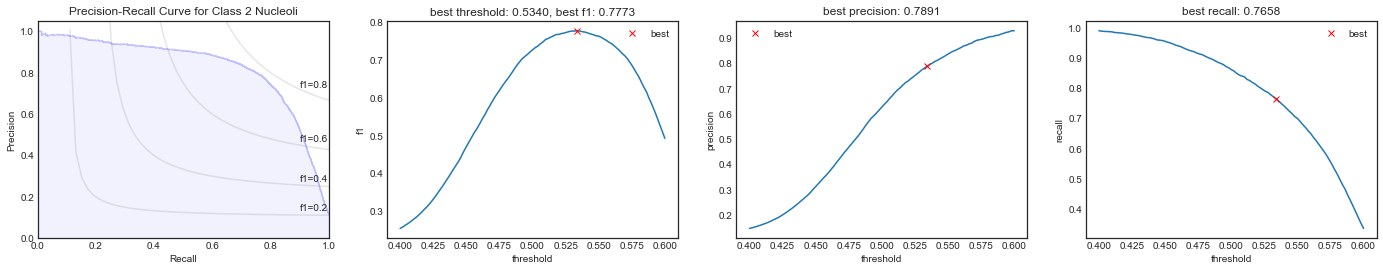

<Figure size 432x288 with 0 Axes>

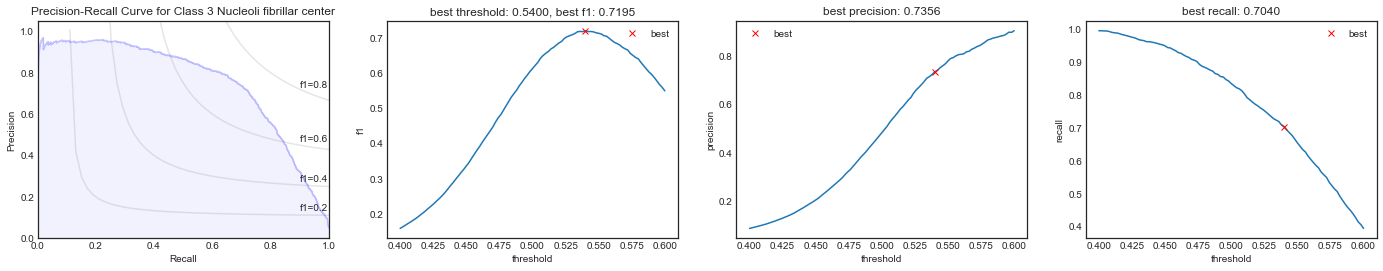

<Figure size 432x288 with 0 Axes>

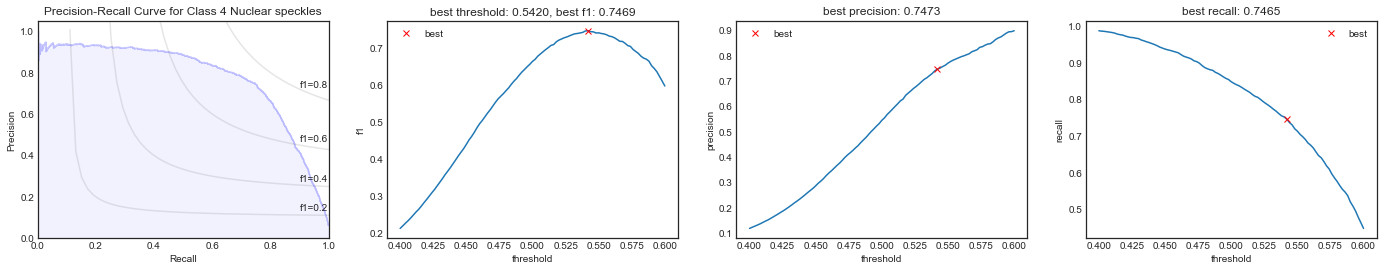

<Figure size 432x288 with 0 Axes>

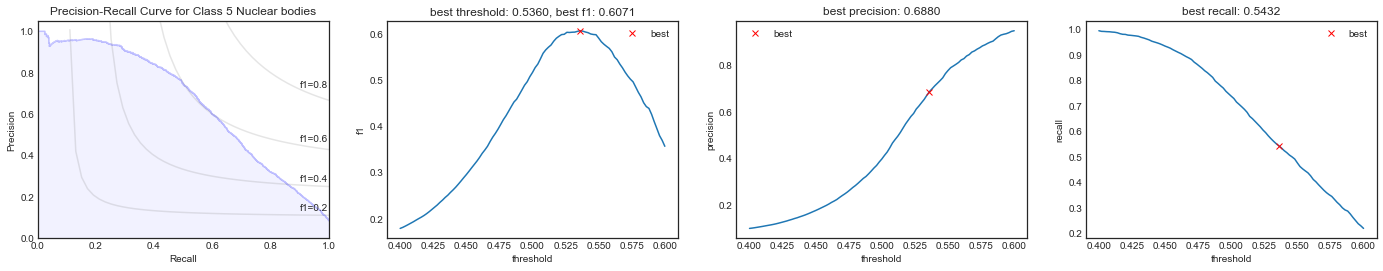

<Figure size 432x288 with 0 Axes>

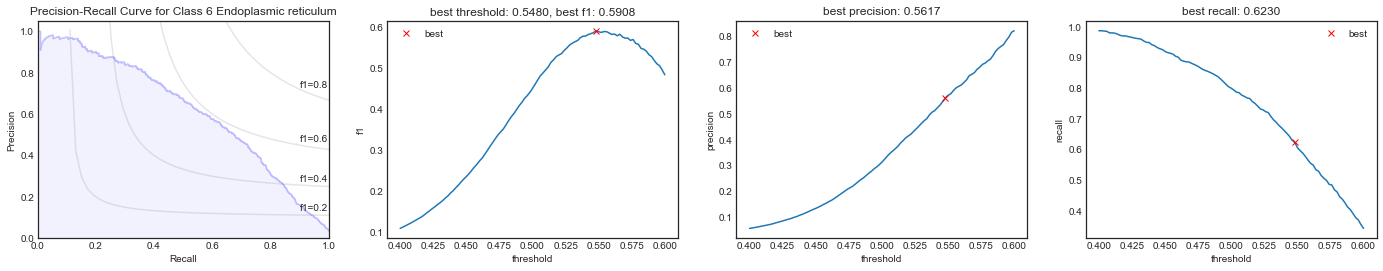

<Figure size 432x288 with 0 Axes>

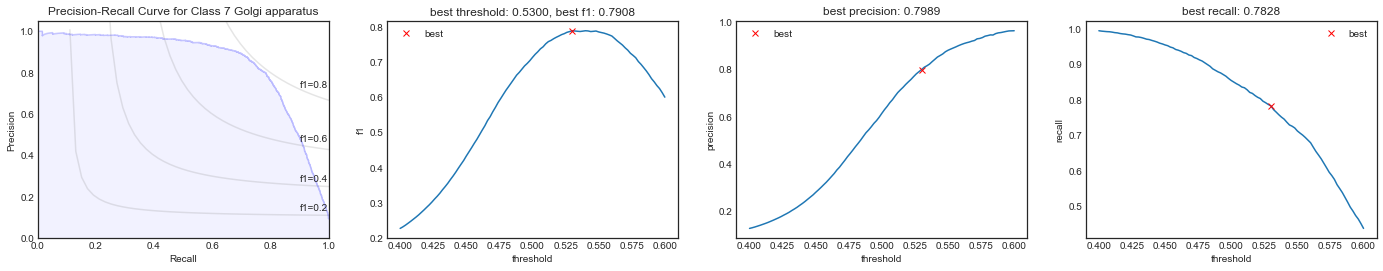

<Figure size 432x288 with 0 Axes>

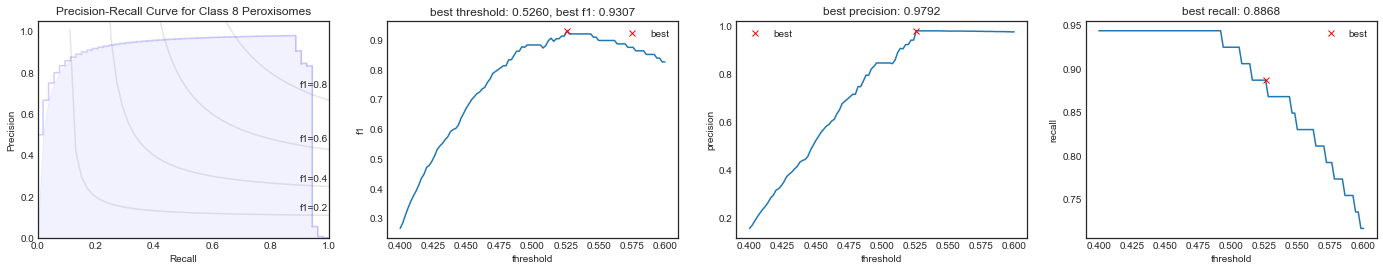

<Figure size 432x288 with 0 Axes>

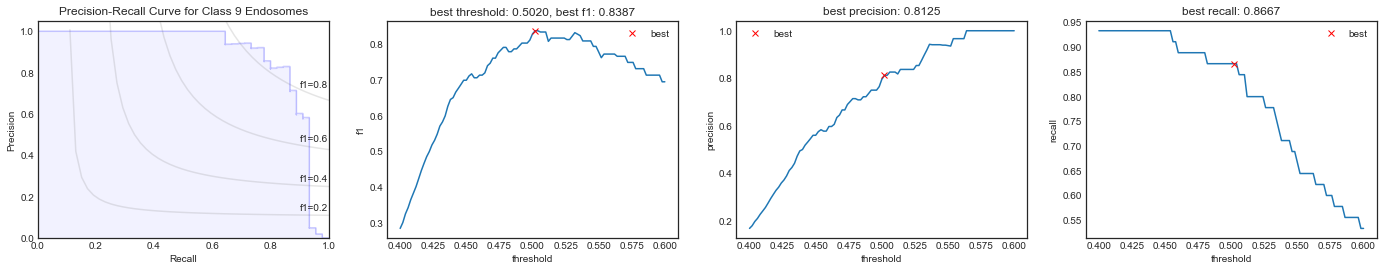

<Figure size 432x288 with 0 Axes>

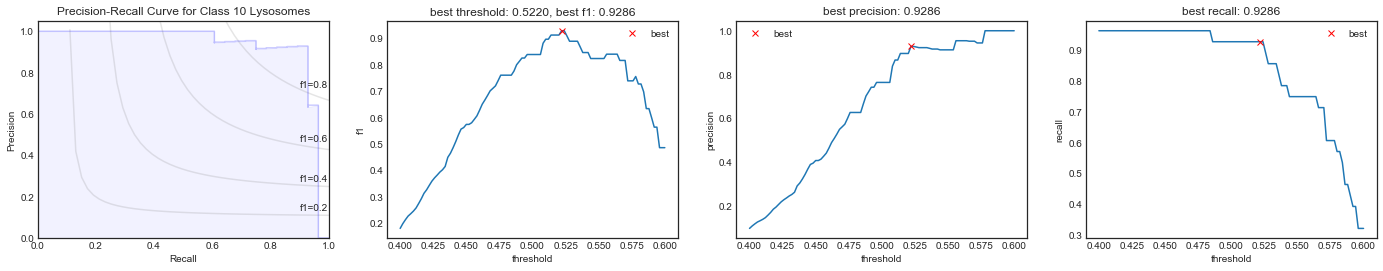

<Figure size 432x288 with 0 Axes>

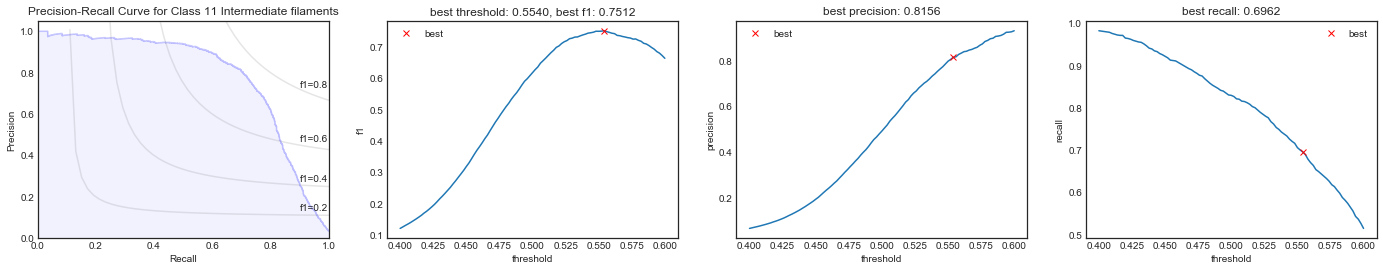

<Figure size 432x288 with 0 Axes>

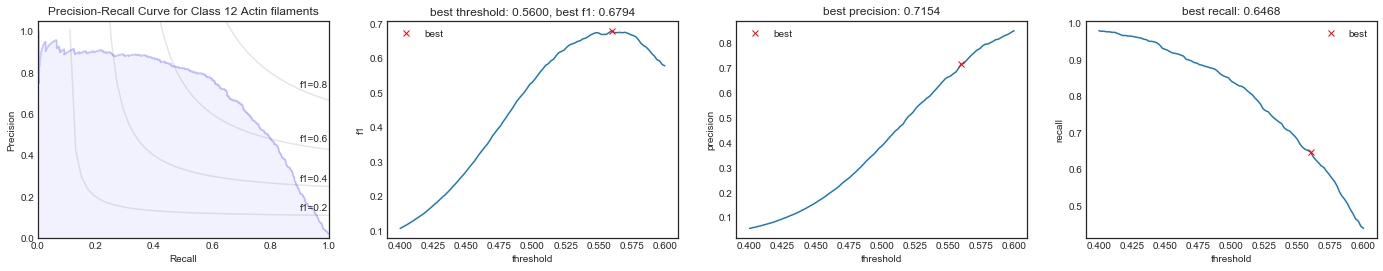

<Figure size 432x288 with 0 Axes>

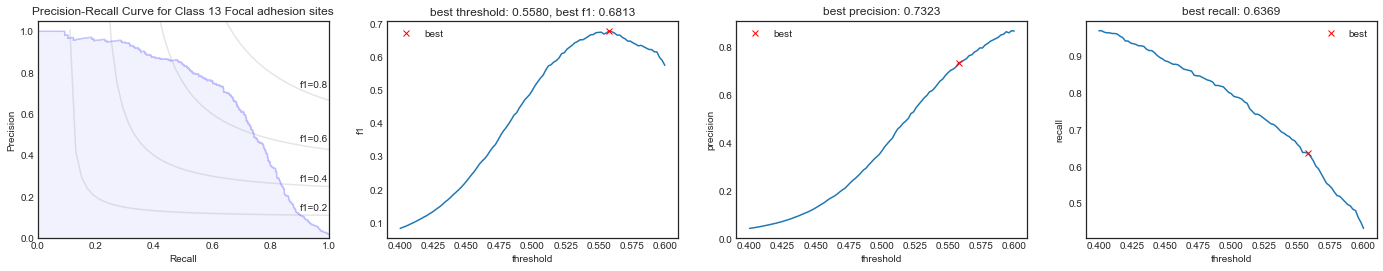

<Figure size 432x288 with 0 Axes>

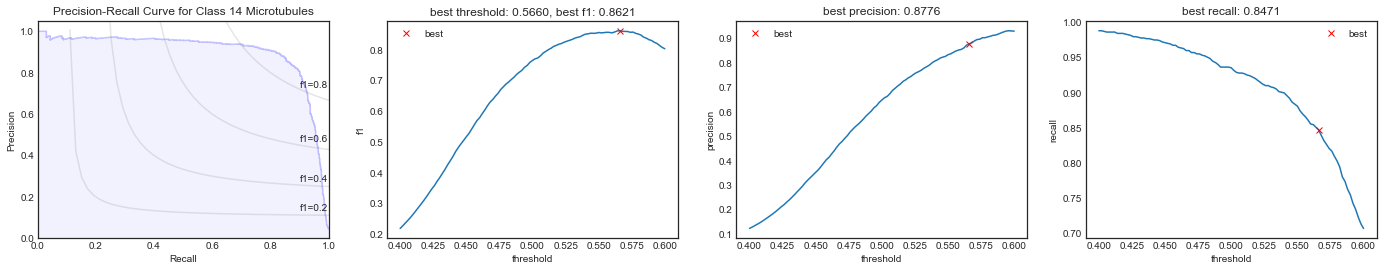

<Figure size 432x288 with 0 Axes>

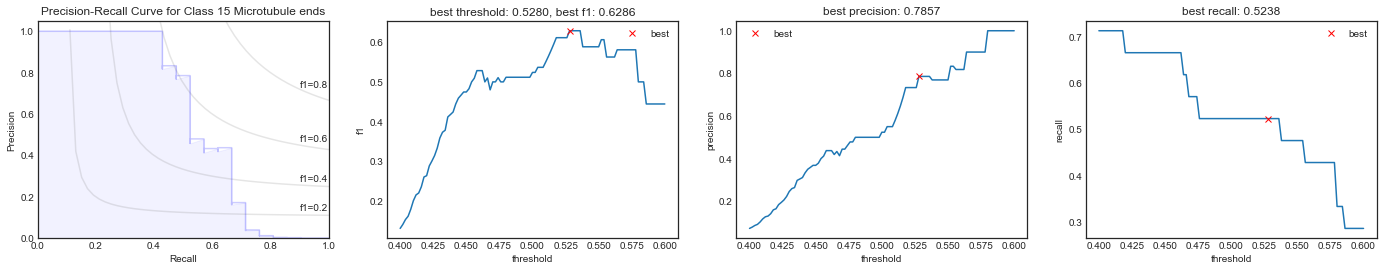

<Figure size 432x288 with 0 Axes>

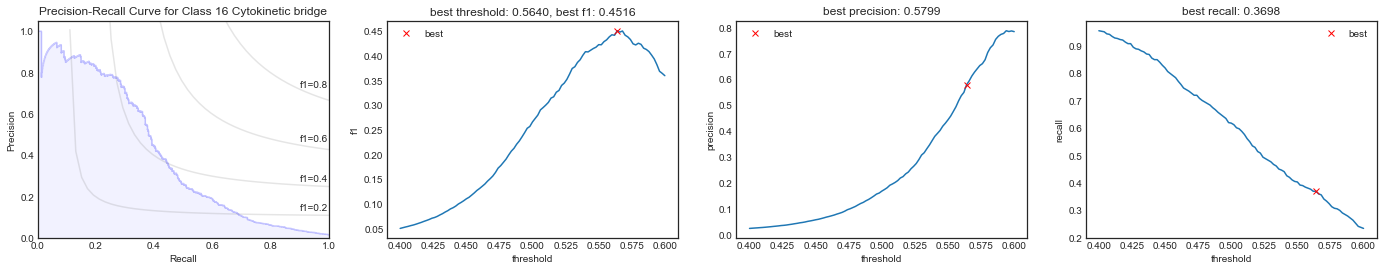

<Figure size 432x288 with 0 Axes>

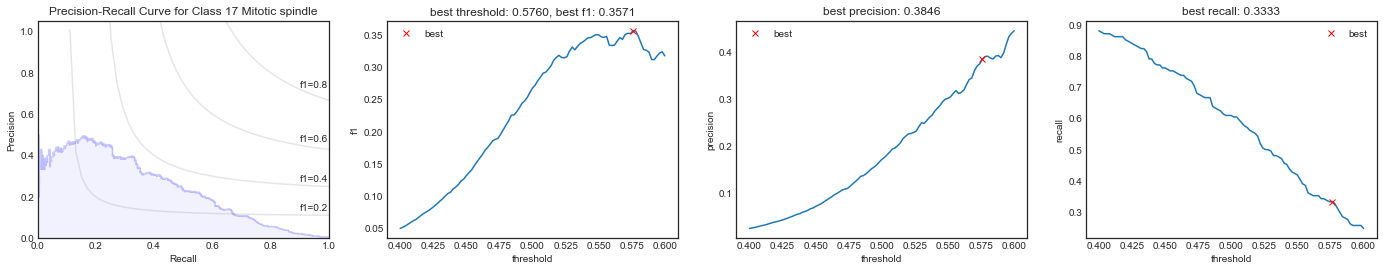

<Figure size 432x288 with 0 Axes>

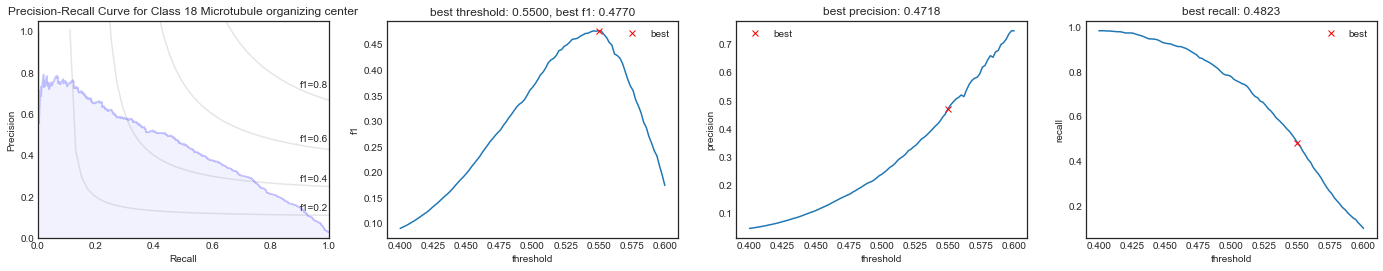

<Figure size 432x288 with 0 Axes>

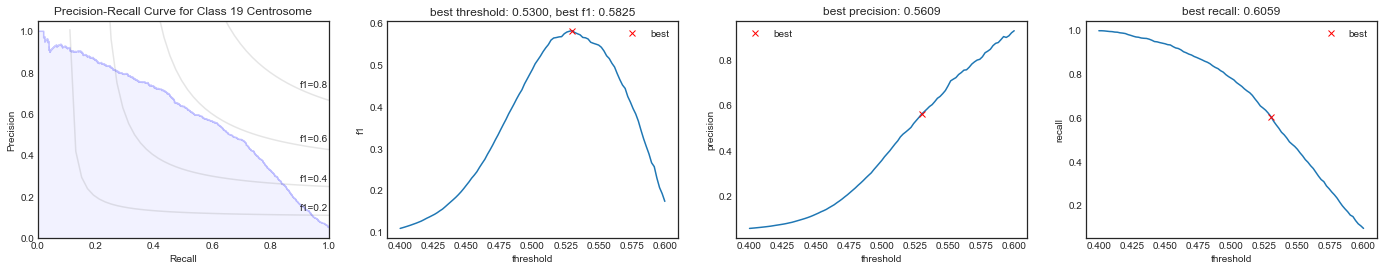

<Figure size 432x288 with 0 Axes>

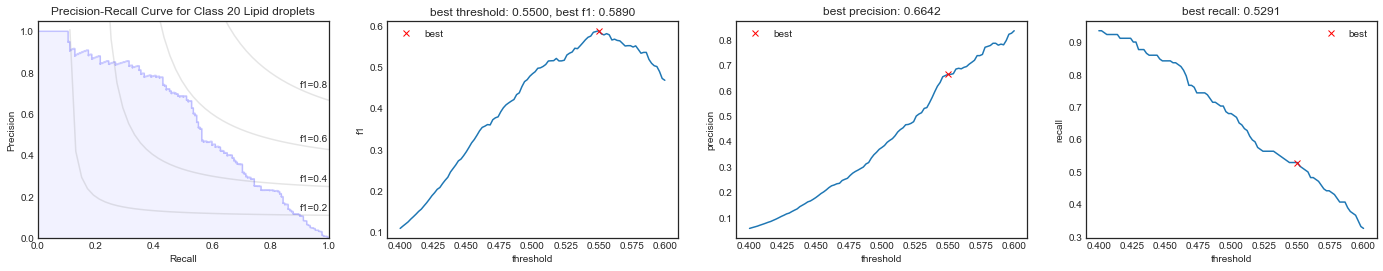

<Figure size 432x288 with 0 Axes>

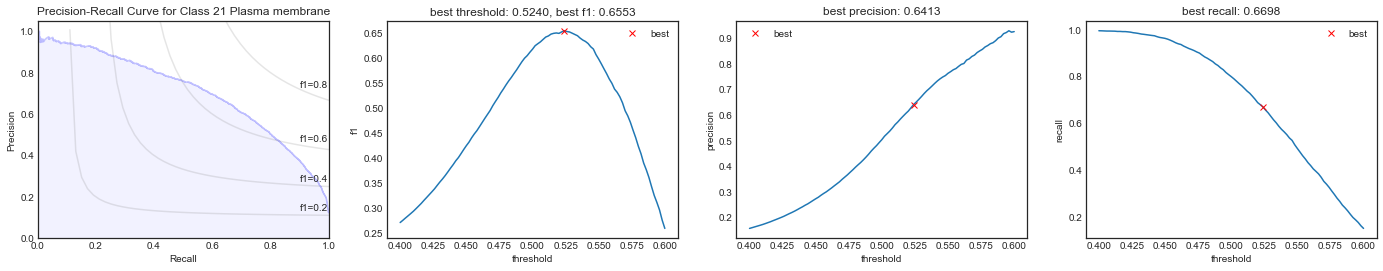

<Figure size 432x288 with 0 Axes>

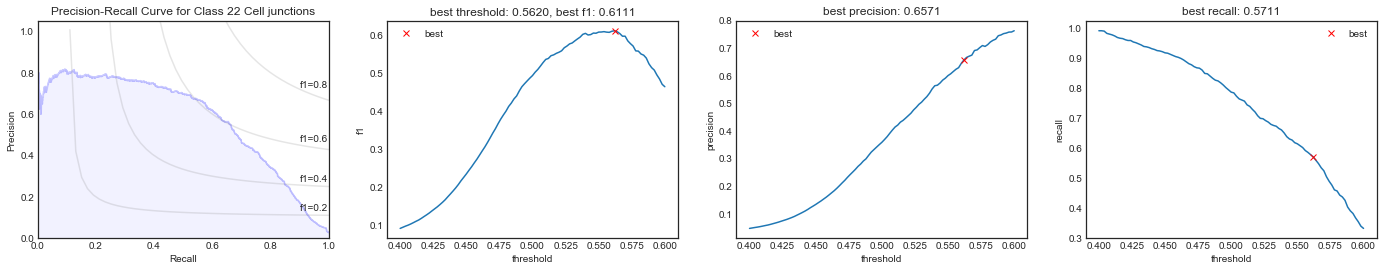

<Figure size 432x288 with 0 Axes>

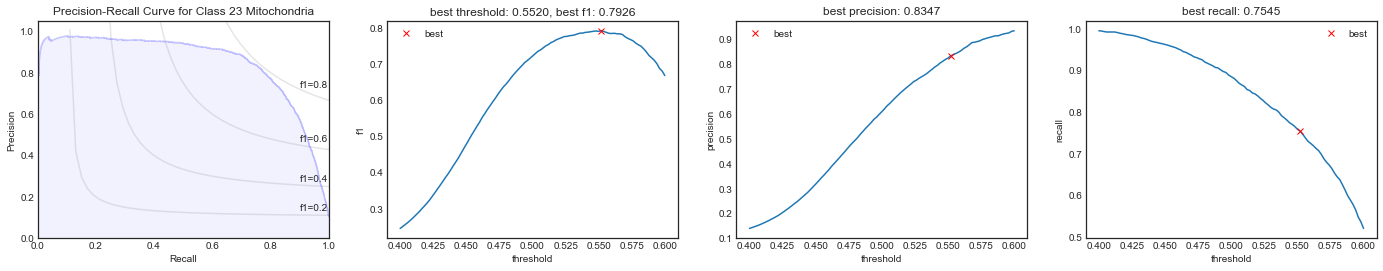

<Figure size 432x288 with 0 Axes>

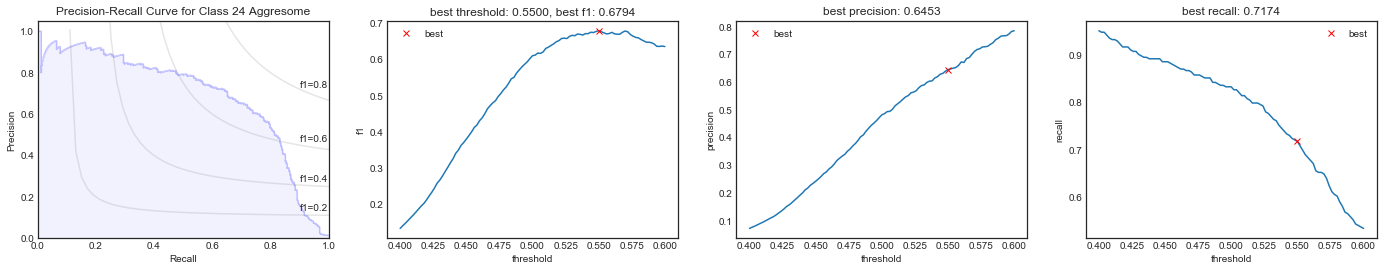

<Figure size 432x288 with 0 Axes>

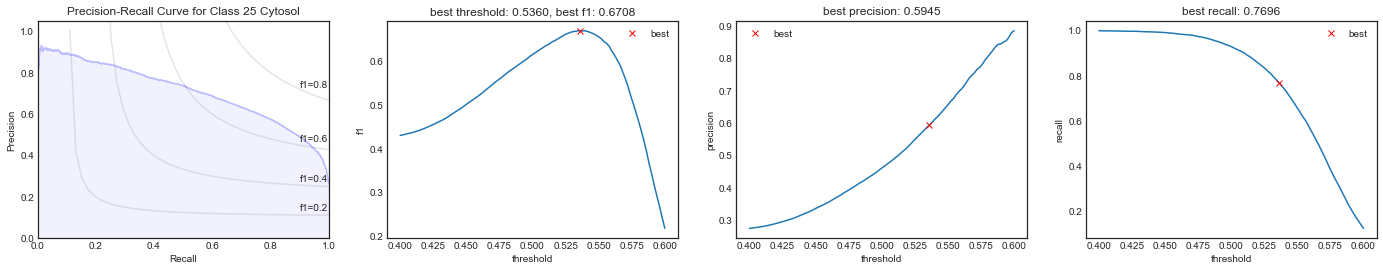

<Figure size 432x288 with 0 Axes>

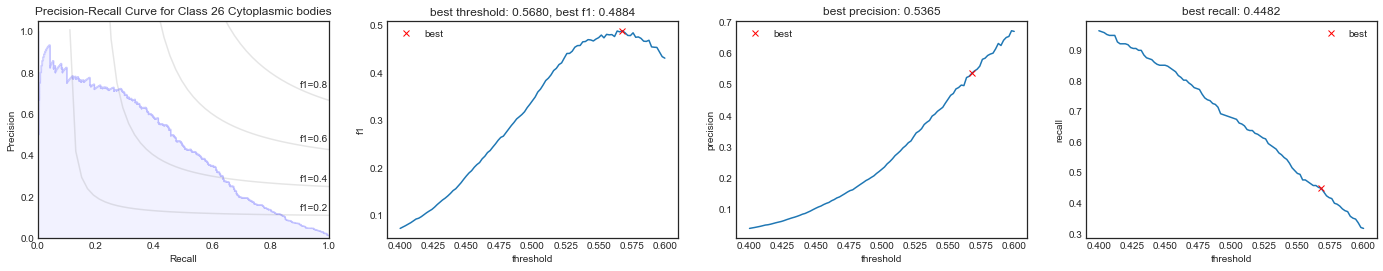

<Figure size 432x288 with 0 Axes>

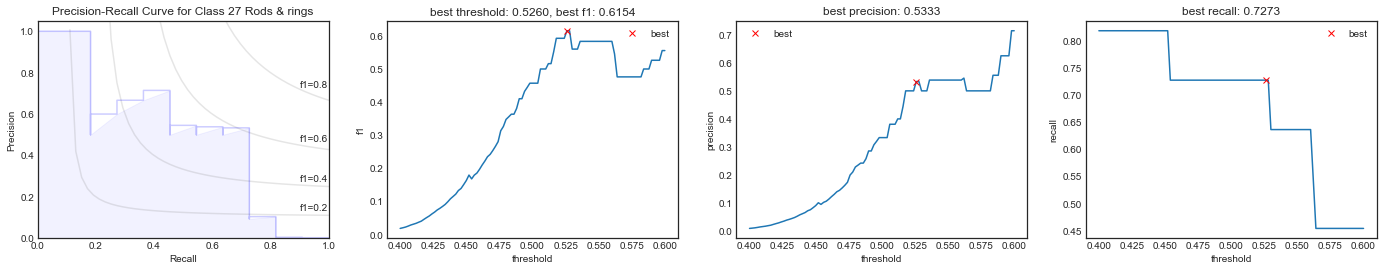

<Figure size 432x288 with 0 Axes>

In [231]:
n_classes = 28

# plot precision-recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()
f_scores = np.linspace(0.2, 0.8, num=4)

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y[:, i], x[:, i])
    average_precision[i] = average_precision_score(y[:, i], x[:, i])
    
#     plt.figure()
    
#     for f_score in f_scores:
#         xf = np.linspace(0.01, 1)
#         yf = f_score * xf / (2 * xf - f_score)
#         l, = plt.plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
#         plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

#     plt.step(recall[i], precision[i], color='b', alpha=0.2, where='post')
#     plt.fill_between(recall[i], precision[i], alpha=0.05, color='b')

#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
#     plt.title(LABEL_MAP[i])
    
    
    fig, axs = plt.subplots(1, 4, figsize=(24, 4))
    
    for f_score in f_scores:
        xf = np.linspace(0.01, 1)
        yf = f_score * xf / (2 * xf - f_score)
        l, = axs[0].plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
        axs[0].annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

    axs[0].step(recall[i], precision[i], color='b', alpha=0.2, where='post')
    axs[0].fill_between(recall[i], precision[i], alpha=0.05, color='b')

    axs[0].set_xlabel('Recall')
    axs[0].set_ylabel('Precision')
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_title('Precision-Recall Curve for Class ' + str(i) + ' ' + LABEL_MAP[i])
    
    
    thresholds = np.linspace(0.4, 0.6, 101)
    # for ranks
    # thresholds = np.linspace(0.8, 1.0, 101)
    fm = [f1_score(y[:,i], (x[:,i] > t).astype(int)) for t in thresholds] 

    besti = np.argmax(fm)
    bestt = thresholds[besti]
    bests = fm[besti] 
        
    axs[1].plot(thresholds, fm)
    axs[1].plot(bestt, bests, "xr", label="best")
    axs[1].set_xlabel("threshold")
    axs[1].set_ylabel("f1")
    axs[1].set_title("best threshold: %6.4f, best f1: %6.4f" % (bestt, bests))
    axs[1].legend()

    pm = [precision_score(y[:,i], (x[:,i] > t).astype(int)) for t in thresholds] 
    bestsp = pm[besti] 
        
    axs[2].plot(thresholds, pm)
    axs[2].plot(bestt, bestsp, "xr", label="best")
    axs[2].set_xlabel("threshold")
    axs[2].set_ylabel("precision")
    axs[2].set_title("best precision: %6.4f" % (bestsp))
    axs[2].legend()
    
    rm = [recall_score(y[:,i], (x[:,i] > t).astype(int)) for t in thresholds] 
    bestsr = rm[besti] 
        
    axs[3].plot(thresholds, rm)
    axs[3].plot(bestt, bestsr, "xr", label="best")
    axs[3].set_xlabel("threshold")
    axs[3].set_ylabel("recall")
    axs[3].set_title("best recall: %6.4f" % (bestsr))
    axs[3].legend()
    
    plt.show()
    plt.gcf().clear()

In [232]:
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y.ravel(), x.ravel())

average_precision["macro"] = average_precision_score(y, x, average="macro")
print('Average precision score, macro-averaged over all classes: {0:0.3f}'
      .format(average_precision["macro"]))

average_precision["micro"] = average_precision_score(y, x, average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.3f}'
      .format(average_precision["micro"]))


Average precision score, micro-averaged over all classes: 0.776
Average precision score, macro-averaged over all classes: 0.692


In [233]:
# for i in range(len(th)):
#     print(i,np.round(th[i],decimals=2))

In [234]:
# print(np.mean(x > th,axis=0))

In [235]:
# f1_score(y, xp, average='samples')

In [236]:
f1_score(y, xp, average='micro')

0.6399477862967717

In [237]:
z = [(y,x) for y,x in zip(y,xp) if np.sum(x) == 0]
print(len(z))

11


In [238]:
# z[:5]

In [239]:
yz = np.array([t[0] for t in z])
xz = np.array([t[1] for t in z])
f1_score(yz,xz,average='macro')

0.0

0.0 0.6564638054258936 1.0


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


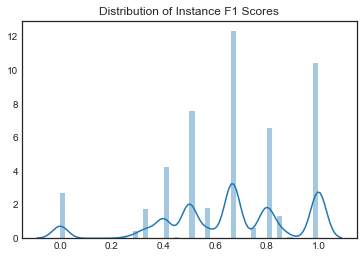

<Figure size 432x288 with 0 Axes>

In [240]:
f1b = np.array([f1_score(yi, xpi, average='binary') \
                 for yi,xpi in zip(y,xp)])
print(f1b.min(),f1b.mean(),f1b.max())
sns.distplot(f1b)
plt.title("Distribution of Instance F1 Scores")
plt.show()
plt.gcf().clear()

In [241]:
np.set_printoptions(precision=3, linewidth=200, suppress=True)
f = []
for m in mnames:
    ff = np.array(list(vp[m])).flatten()
    print(m, ff.shape)
    f.append(ff)
# print(mnames)
r = np.corrcoef(f)
print(r)   

iv3_q11 (870016,)
irv2_q10 (870016,)
resnet_q24 (870016,)
resnet_q25 (870016,)
resnet_q40 (870016,)
gap_q12 (870016,)
nas_q11 (870016,)
se_resnext_q26 (870016,)
bni_q0 (870016,)
bni_q1 (870016,)
iv3_q12 (870016,)
iv3_u11 (870016,)
resnet_q26 (870016,)
resnet_q27 (870016,)
resnet_u25 (870016,)
resnet_u31 (870016,)
resnet_u56 (870016,)
resnet_u101 (870016,)
gap_u14 (870016,)
bni_u1 (870016,)
[[1.    0.878 0.899 0.902 0.886 0.876 0.838 0.859 0.888 0.891 0.967 0.867 0.863 0.873 0.879 0.852
  0.833 0.842 0.872 0.886]
 [0.878 1.    0.896 0.897 0.881 0.871 0.844 0.857 0.896 0.891 0.854 0.873 0.856 0.871 0.88  0.859
  0.826 0.834 0.866 0.887]
 [0.899 0.896 1.    0.951 0.948 0.928 0.873 0.882 0.928 0.922 0.876 0.884 0.916 0.916 0.926 0.891
  0.831 0.845 0.883 0.92 ]
 [0.902 0.897 0.951 1.    0.944 0.922 0.87  0.883 0.932 0.934 0.878 0.888 0.955 0.957 0.932 0.895
  0.845 0.854 0.888 0.924]
 [0.886 0.881 0.948 0.944 1.    0.924 0.869 0.873 0.922 0.926 0.86  0.871 0.907 0.911 0.922 0.886
  0.823 0

In [242]:
loc = [i for i,m in enumerate(mnames) if m == special][0]
rloc = r[:,loc]
print(rloc)
order = np.argsort(rloc)
for i in range(1,min(len(rloc)+1,7)):
    print('%5.3f' % rloc[order[-i]],mnames[order[-i]])

[0.842 0.834 0.845 0.854 0.835 0.816 0.794 0.827 0.859 0.862 0.835 0.839 0.835 0.842 0.857 0.824
 0.92  1.    0.87  0.863]
1.000 resnet_u101
0.920 resnet_u56
0.870 gap_u14
0.863 bni_u1
0.862 bni_q1
0.859 bni_q0


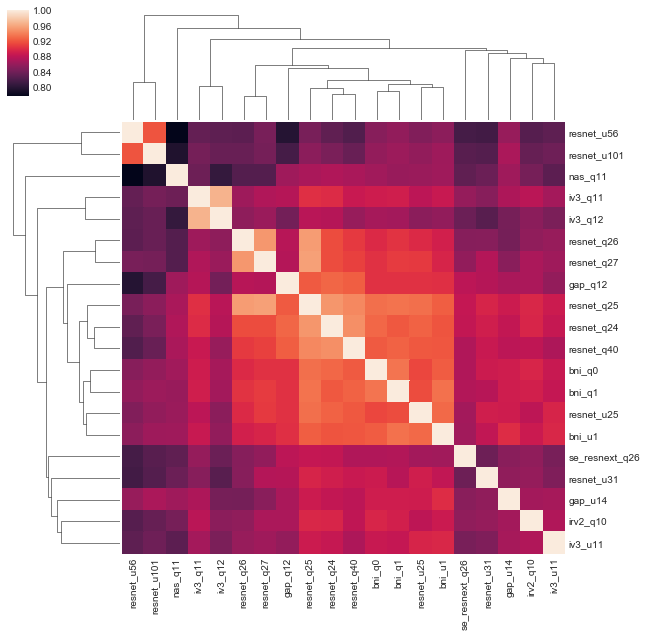

In [243]:
d = pd.DataFrame(r, columns=mnames)
d['id'] = mnames
d.set_index('id',inplace=True)
del d.index.name

sns.clustermap(d)


# import scipy.cluster.hierarchy as hc
# from matplotlib import pyplot
# link = hc.linkage(d.values, method='centroid')
# o1 = hc.leaves_list(link)

# mat = d.iloc[o1,:]
# mat = mat.iloc[:, o1[::-1]]
# pyplot.imshow(mat)

In [244]:
# f = []
# for m in mnames:
#     f.append(np.array(list(vp[m])).flatten())
# print(mnames)
# print(np.corrcoef(f))   

In [245]:
print(f[0].min(),f[0].max())

0.003531752538329119 0.873710232392001


In [246]:
# # model-specific global thresholds
# # compute best single logit threshold for computed ensemble

# # for probabilities
# thresholds = np.linspace(0.1, 0.9, 1001)

# # for logits
# # thresholds = np.linspace(-1, 1, 101)

# # for ranks
# # thresholds = np.linspace(0.9, 1, 101)

# # thresholds = [-0.4]

# fname = 'mthresh.pkl'
# if os.path.isfile(fname): mthresh = pickle.load(open(fname,'rb'))
# else: mthresh = {}
# # mthresh = {}

# for i in range(nm):
# # for i in [3]:

#     mname = vp.columns[i+offset]

#     tv = np.array(list(vp.iloc[:,offset+i].values))
    
#     if mname in mthresh or np.sum(np.isnan(tv)) > 0: continue

#     scores = np.array([f1_score(y, np.int32(tv > threshold),
#                                  average='macro') for threshold in thresholds])

#     besta = np.argmax(scores)
#     threshold_best = thresholds[besta]
#     score_best = scores[besta]
#     print(i, mname, "%4.2f" % threshold_best, "%6.4f" % score_best)
#     mthresh[mname] = threshold_best
    
#     plt.plot(thresholds, scores)
#     plt.plot(threshold_best, score_best, "xr", label="best")
#     plt.xlabel("threshold")
#     plt.ylabel("f1")
# #     plt.title(mname + " f1 vs threshold (%6.4f, %6.4f)" % (threshold_best, score_best))
#     plt.title(mname + " threshold: %6.4f  f1: %6.4f" % (threshold_best, score_best))
#     plt.legend()
#     plt.show()
#     plt.gcf().clear()

# pickle.dump(mthresh,open(fname,'wb'))
# print(mthresh)

In [247]:
vp.columns

Index(['Target', 'y', 'iv3_q11', 'irv2_q10', 'resnet_q24', 'resnet_q25',
       'resnet_q40', 'gap_q12', 'nas_q11', 'se_resnext_q26', 'bni_q0',
       'bni_q1', 'iv3_q12', 'iv3_u11', 'resnet_q26', 'resnet_q27',
       'resnet_u25', 'resnet_u31', 'resnet_u56', 'resnet_u101', 'gap_u14',
       'bni_u1'],
      dtype='object')

In [248]:
# # model- and class-specific thresholds
# # compute best logit threshold for computed ensemble

# # thresholds = np.linspace(-2, 2, 101)

# # thresholds = [-0.4]

# fname = 'cthresh.pkl'
# # if os.path.isfile(fname): cthresh = pickle.load(open(fname,'rb'))
# cthresh = {}

# for i in range(nm):
# # for i in [2]:

#     mname = vp.columns[i+offset]
#     tv = np.array(list(vp.iloc[:,offset+i].values))

#     fm = [[f1_score(y[:,j], (tv[:,j] > t).astype(int)) \
#            for t in thresholds] for j in range(y.shape[1])]
    
#     besti = [np.argmax(f) for f in fm]
#     bestt = [thresholds[b] for b in besti]
#     bests = [f[b] for f,b in zip(fm,besti)]
#     print(mname, np.mean(bests))
    
#     td = {}
#     for j in range(y.shape[1]):
#         # print()
#         # print(j, LABEL_MAP[j], "%4.2f" % bestt[j], "%6.4f" % bests[j])
        
#         # print(j, "%4.2f" % bestt[j], "%6.4f" % bests[j], LABEL_MAP[j])
        
#         # print(cm[j], '%4.2f' % fm[j])
#         # print('')
#         td[j] = np.round(bestt[j],decimals=2)
    
#     cthresh[mname] = td
#     print()
    
# pickle.dump(cthresh,open(fname,'wb'))
# # print(cthresh)
# print(fname)

optimizing f1 by hillcliming
model 0 f1 for iv3_q11 = 0.6371
model 1 f1 for irv2_q10 = 0.6203
model 2 f1 for resnet_q24 = 0.6337
model 3 f1 for resnet_q25 = 0.6278
model 4 f1 for resnet_q40 = 0.6229
model 5 f1 for gap_q12 = 0.6127
model 6 f1 for nas_q11 = 0.5267
model 7 f1 for se_resnext_q26 = 0.5831
model 8 f1 for bni_q0 = 0.6300
model 9 f1 for bni_q1 = 0.6180
model 10 f1 for iv3_q12 = 0.6473
model 11 f1 for iv3_u11 = 0.6555
model 12 f1 for resnet_q26 = 0.6268
model 13 f1 for resnet_q27 = 0.6554
model 14 f1 for resnet_u25 = 0.6527
model 15 f1 for resnet_u31 = 0.6539
model 16 f1 for resnet_u56 = 0.6895
model 17 f1 for resnet_u101 = 0.6812
model 18 f1 for gap_u14 = 0.6253
model 19 f1 for bni_u1 = 0.6468
step = 0   index = 16   name = resnet_u56    f1 = 0.6895
    try 0 iv3_q11 0.6973
    try 1 irv2_q10 0.6950
    try 2 resnet_q24 0.6993
    try 3 resnet_q25 0.6992
    try 4 resnet_q40 0.6972
    try 5 gap_q12 0.6818
    try 6 nas_q11 0.6818
    try 7 se_resnext_q26 0.6729
    try 8 bni_

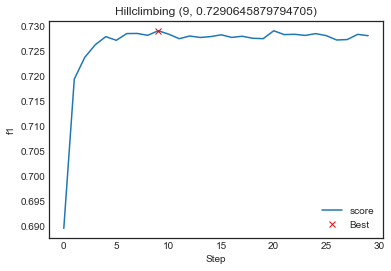

   step  midx     score          mod      f1_0
0     0    16  0.689526   resnet_u56  0.689526
1     1    15  0.719396   resnet_u31  0.653915
2     2    13  0.723744   resnet_q27  0.655447
3     3    17  0.726272  resnet_u101  0.681225
4     4    15  0.727887   resnet_u31  0.653915
5     5    15  0.727152   resnet_u31  0.653915
6     6    16  0.728498   resnet_u56  0.689526
7     7    13  0.728525   resnet_q27  0.655447
8     8    15  0.728148   resnet_u31  0.653915
9     9    16  0.729065   resnet_u56  0.689526

      weight          mod      f1_0
midx                               
13         2   resnet_q27  0.655447
15         4   resnet_u31  0.653915
16         3   resnet_u56  0.689526
17         1  resnet_u101  0.681225


<Figure size 432x288 with 0 Axes>

In [249]:
# oof = small

# hillclimbing
# vp = oof.copy()
# offset = 5
# nm = vp.shape[1] - offset
nr = vp.shape[0]
y = np.array([y for y in vp.y])
# y = np.array(list(vp['masks'].values))
nstep = 30

step0fix = -1
# step0fix = 5
step1fix = -1

intercept = 0
rez = pd.DataFrame({'step':np.zeros(nstep).astype(int),'midx':np.zeros(nstep).astype(int),
                    'score':np.zeros(nstep)})
currEnsemble = 0 * np.array(list(vp.iloc[:,offset].values))

metric = 'f1'
# metric = 'iou'

# threshold = 0.
# threshold = 0.36
threshold = 0.49
# threshold = 0.5
# print('using ' + metric + ' threshold',threshold)
print('optimizing ' + metric + ' by hillcliming')


# metric = "mcc"
# metric = "corr"
# metric = "rmse"
# metric = "mse"
# metric = "mae"
# metric = "winsorized_mae"
# metric = "auc"

cut_mets = ['mcc']

num_classes = 28
th = np.zeros(num_classes)
threshold_best = threshold

# maximizing
bestScore = -9999999
single = pd.DataFrame({'mod':np.repeat("",nm)})
start = 0
for step in range(start,nstep):
    single[metric+'_'+str(step)] = np.nan

for step in range(start,nstep):
    currIndex = 0
    currScore = -9999999

    for i in range(nm):

        mname = vp.columns[i+offset]
        
        tv = np.array(list(vp.iloc[:,offset+i].values))

        # mean-center
#         tv = tv - np.mean(tv)

        # adjust by model-specific threshold
#         tv = tv - mthresh[mname]
        
        # adjust by model-class-specific thresholds
#         for j in range(tv.shape[1]):
#             tv[:,j] = tv[:,j] - cthresh[mname][j]

        if np.sum(np.isnan(tv)) > 0: continue
            
        if step==0:
            tryEnsemble = tv
        else:
            # running mean
            tryEnsemble = (step * currEnsemble + tv)/(step+1)
            # full matrix
            # choose median or mean here
            # tryEnsemble = rowMedians(cbind(currEnsemble,tv))
            # tryEnsemble = rowMeans(cbind(currEnsemble,tv))
            # quantiles are a lot slower
            # tryEnsemble = rowQuantiles(cbind(currEnsemble,tv),probs=0.6)

        if metric=="f1":
#             # estimate new class-specific thresholds by least squares, very slow
#             th = fit_val(tryEnsemble,y)
#             th[th<0.1] = 0.1
#             tryScore = f1_score(y, np.int32(tryEnsemble > th),
#                                 average='macro')

            # estimate new class-specific thresholds by line search, slow
            for j in range(num_classes):
                th[j] = fit_val1(tryEnsemble[:,j],y[:,j])
            tryScore = f1_score(y, np.int32(tryEnsemble > th),
                                average='macro')
            
#             # estimate new class-specific thresholds to match proportions, medium
#             for j in range(num_classes):
#                 th[j] = fit_val2(tryEnsemble[:,j],y[:,j])
#             tryScore = f1_score(y, np.int32(tryEnsemble > th),
#                                 average='macro')

#             # fixed threshold, fast
#             tryScore = f1_score(y, np.int32(tryEnsemble > threshold),
#                                 average='macro')

            if step > 0: print('    try',i,mname,"%6.4f" % tryScore)
        elif metric=="iou":
            tryScore = iou_metric_batch(y, np.int32(tryEnsemble > threshold),
                                        pred_eps=pred_eps)
            if step > 0: print('    try',i,mname,"%6.4f" % tryScore)
        elif metric=="mse":
            tryScore = -mse(y,tryEnsemble)
        elif metric=="mae": 
            tryScore = -mae(y,tryEnsemble)
        elif metric=="winsorized_mae": 
            tryScore = -winsorized_mae(y,tryEnsemble+intercept)
        elif metric=="rmse":
            tryScore = -rmse(y,tryEnsemble)
        elif metric=="corr":
            tryScore = cor(y,tryEnsemble)
        elif metric=="mcc":
            opt = eval_mcc3(y,tryEnsemble,cut=T)
            tryScore = opt[1]
            cut = opt[2]
            # opt = optimize(mcc,c(0.1,0.3),tryEnsemble,vp$y,maximum=T)
            # tryScore = opt$objective
        elif metric=="logloss":
            # tryScore = -logLoss(vp$y,tryEnsemble,)
            tryScore = -eval_logloss2(tryEnsemble,y)
        elif metric=="auc":
            tryScore = auc2(y,tryEnsemble)
        elif metric=="auprc":
            tryScore = auprc(tryEnsemble, y)
            # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
            # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.davis.goadrich
        elif metric=="aurocpr":
            auroc = auc(y,tryEnsemble)
            # auprc = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
            tryScore = (auroc + auprc)/2
        elif metric=="sqwk":
            tryScore = sqwk(y,tryEnsemble,1,8)
        
        ok = 1
        if (step==0) and (step0fix>-1) and (i!=step0fix): ok = 0 
        if (step==1) and (step1fix>-1) and (i!=step1fix): ok = 0 

        if (tryScore > currScore) and (ok==1):
            currIndex = i
            currScore = tryScore
            if (step==0):
                saveEnsemble = tv.copy()
            else:
                # running mean
                saveEnsemble = tryEnsemble.copy()
                # save whole matrix
                # saveEnsemble = np.concatenate((currEnsemble,tv),axis=1)
            if metric in cut_mets: currCut = cut

        # if (step==0) or ((step==1) and (step0fix>-1)) or ((step==2) and (step1fix>-1)):
        if (step==0):
            if (metric=="mcc"):
                print("model",i,metric,"for",vp.columns[i+offset],"=",tryScore,"  cut =",cut,"\n")
            else:
                print("model",i,metric,"for",vp.columns[i+offset],"= %6.4f" % tryScore)

        if step==0:
            single.loc[i,'mod'] = vp.columns[i+offset]  
        single.iloc[i,step+1] = tryScore

    if metric=="mcc":
        print("step =",step,"  index =",currIndex,"  name =", vp.columns[currIndex+offset],"  ",
            metric,"= %6.4f" % currScore,"  cut =",currCut)
    else:
        print("step =",step,"  index =",currIndex,"  name =", vp.columns[currIndex+offset],"  ",
            metric,"= %6.4f" % currScore)

    currEnsemble = saveEnsemble.copy()
    if currScore > bestScore:
        bestScore = currScore
        bestStep = step
        bestEnsemble = currEnsemble.copy()
        if metric in cut_mets: bestCut = currCut

    rez.iloc[step,0] = step
    rez.iloc[step,1] = currIndex
    rez.iloc[step,2] = currScore

if (metric=="mcc"):
    print("best step =",bestStep,"  best",metric,"=",bestScore,"  best cut =",bestCut)
else:
    print("best step =",bestStep,"  best",metric,"=",bestScore)

rez0 = rez.copy()

# tb = table(rez$index[1:bestStep])
# names(tb) = names(vp)[(offset+1):ncol(vp)][as.integer(names(table(rez$index[1:bestStep])))]

# if (intercept!=0) {
#   tb["Intercept"] = intercept
# }

# print(tb[order(-tb)])
# print(single[order(-single[,2]),][1:min(nrow(single),40),])

# plot hillclimbing
print('')
plt.plot(rez0.step, rez0.score)
plt.plot(bestStep, bestScore, "xr", label="Best")
plt.xlabel("Step")
plt.ylabel(metric)
plt.title("Hillclimbing ({}, {})".format(bestStep, bestScore))
plt.legend()
plt.show()
plt.gcf().clear()

# display the weights
rez = rez.iloc[:(bestStep+1)]
# print(rez)

single0 = single.iloc[:,:2]

rez['midx'] = rez['midx'].astype(int)
rez = rez.join(single0,how='left',on='midx')
print(rez)
print('')

rez['weight'] = 1
tb = rez.loc[:,['midx','weight']].groupby('midx').count()
# print(tb)
# print(single)

tb = tb.join(single0,how='left')
print(tb)

bestEnsemble0 = bestEnsemble.copy()

In [250]:
pred = bestEnsemble0
num_classes = x.shape[1]
print(pred.min(),pred.mean(),pred.max(),num_classes)
name_label_dict = LABEL_MAP
th = np.zeros(num_classes)
for i in range(num_classes):
    th[i] = fit_val1(pred[:,i],y[:,i])
# th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

0.12380090784160447 0.3929080416371708 0.6462550693617389 28
Thresholds:  [0.53  0.525 0.521 0.518 0.522 0.521 0.539 0.518 0.502 0.476 0.501 0.526 0.545 0.535 0.543 0.493
 0.524 0.522 0.518 0.517 0.522 0.518 0.53  0.52  0.52  0.519 0.526 0.52 ]
F1 macro:  0.7290645879794705
F1 micro:  0.75461082184204


In [251]:
pred = bestEnsemble0
num_classes = x.shape[1]
print(pred.min(),pred.mean(),pred.max(),num_classes)
name_label_dict = LABEL_MAP
th1 = np.zeros(num_classes)
for i in range(num_classes):
    th1[i] = fit_val2(pred[:,i],y[:,i])
# th[th<0.1] = 0.1
print('Thresholds: ',th1)
print('F1 macro: ',f1_score(y, pred>th1, average='macro'))
print('F1 micro: ',f1_score(y, pred>th1, average='micro'))

0.12380090784160447 0.3929080416371708 0.6462550693617389 28
Thresholds:  [0.537 0.533 0.52  0.518 0.523 0.514 0.538 0.511 0.482 0.476 0.5   0.517 0.535 0.521 0.543 0.476
 0.52  0.516 0.524 0.522 0.506 0.523 0.538 0.518 0.515 0.53  0.511 0.524]
F1 macro:  0.723572299694804
F1 micro:  0.7492956636523042


(0.4598389242695569, 0.5589869202167366)

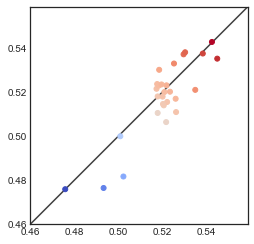

In [252]:
c = th**2 + th1**2

fig, ax = plt.subplots()
ax.scatter(th, th1, s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against each other
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
# fig.savefig('/Users/paul/Desktop/so.png', dpi=300)

In [253]:
from sklearn import linear_model

lm = linear_model.LinearRegression()

best = np.array(th)
approx = np.array(th1).reshape(-1, 1)
model = lm.fit(approx,best)

th1p = lm.predict(approx)
print(th1p)

print(lm.intercept_)
print(lm.coef_)
print(lm.score(approx,best))
print('F1 macro: ',f1_score(y, pred>th1p, average='macro'))

[0.535 0.532 0.522 0.521 0.524 0.518 0.535 0.515 0.495 0.491 0.508 0.52  0.533 0.523 0.539 0.491
 0.522 0.519 0.525 0.523 0.512 0.524 0.535 0.521 0.518 0.53  0.516 0.525]
0.14943959225238584
[0.717]
0.7633289465393086
F1 macro:  0.7244470876994662


(0.4641288581374412, 0.5568090542023748)

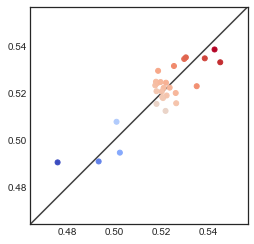

In [254]:
c = th**2 + th1**2

fig, ax = plt.subplots()
ax.scatter(th, th1p, s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
# fig.savefig('/Users/paul/Desktop/so.png', dpi=300)

In [255]:
# # estimate thresholds by line search on observed proportions
# def prop_mse(preds, targs, th=0.5):
#     return (np.mean(targs) - np.mean((preds>th)))**2

# def fit_val2(x, y, start=0.5):
#     params = np.array([start])
#     wd = 1e-5
# #     error = lambda p: np.array(F1_hard(x,y,p), wd*(p - 0.5))
#     error = lambda p: np.array(prop_mse(x,y,p))
#     p = opt.minimize_scalar(error, bounds=[0.,1.0], method='bounded').x
# #     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='brent').x
# #     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='golden').x
#     return p

In [256]:
# # estimate thresholds by line search
# def F1_hard(preds, targs, th=0.5):
#     return -f1_score(targs,  (preds>th).astype(int))

# def fit_val1(x, y, start=0.5):
#     params = np.array([start])
#     wd = 1e-5
# #     error = lambda p: np.array(F1_hard(x,y,p), wd*(p - 0.5))
#     error = lambda p: np.array(F1_hard(x,y,p))
#     p = opt.minimize_scalar(error, bounds=[0.,1.0], method='bounded').x
# #     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='brent').x
# #     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='golden').x
#     return p

In [257]:
# pred = x
# num_classes = x.shape[1]
# print(pred.min(),pred.mean(),pred.max(),num_classes)
# name_label_dict = LABEL_MAP
# th = np.zeros(num_classes)
# for i in range(num_classes):
#     th[i] = fit_val2(pred[:,i],y[:,i])
# # th[th<0.1] = 0.1
# print('Thresholds: ',th)
# print('F1 macro: ',f1_score(y, pred>th, average='macro'))
# print('F1 micro: ',f1_score(y, pred>th, average='micro'))

f1_score(y, pred>1.001*th1, average='macro')

0.724256827296381

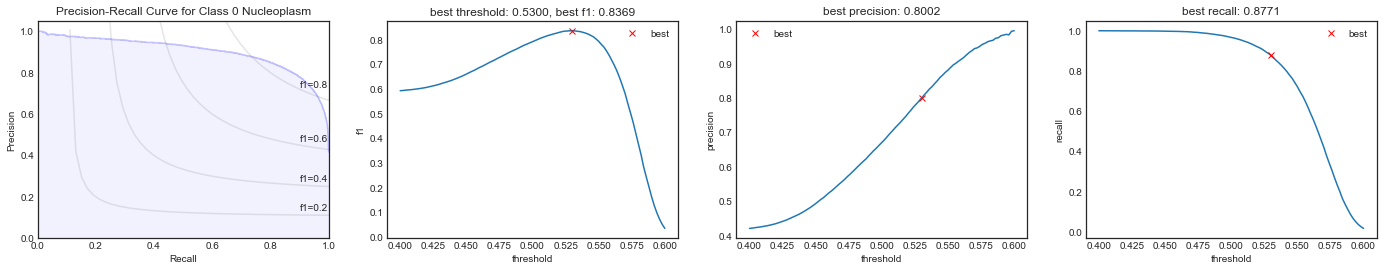

<Figure size 432x288 with 0 Axes>

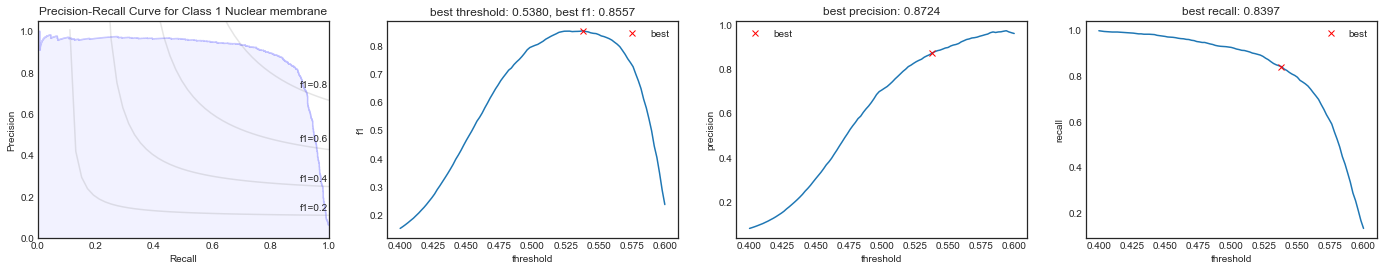

<Figure size 432x288 with 0 Axes>

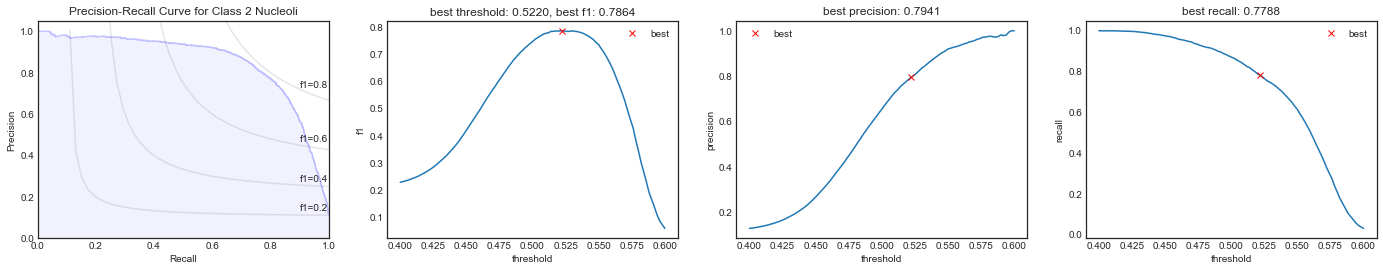

<Figure size 432x288 with 0 Axes>

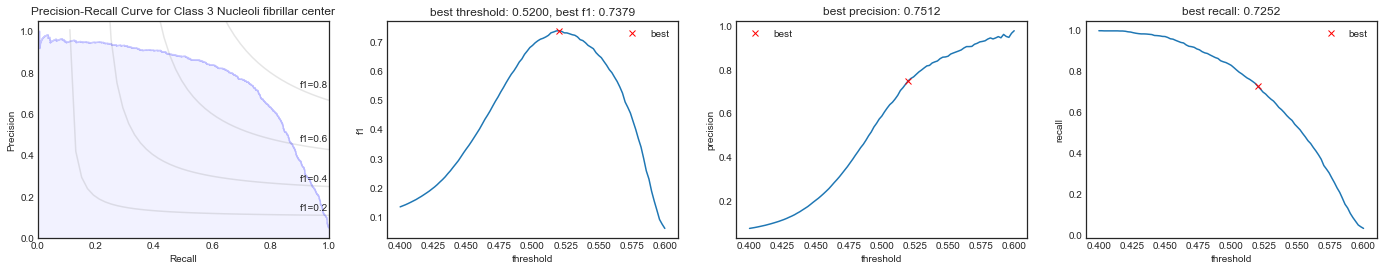

<Figure size 432x288 with 0 Axes>

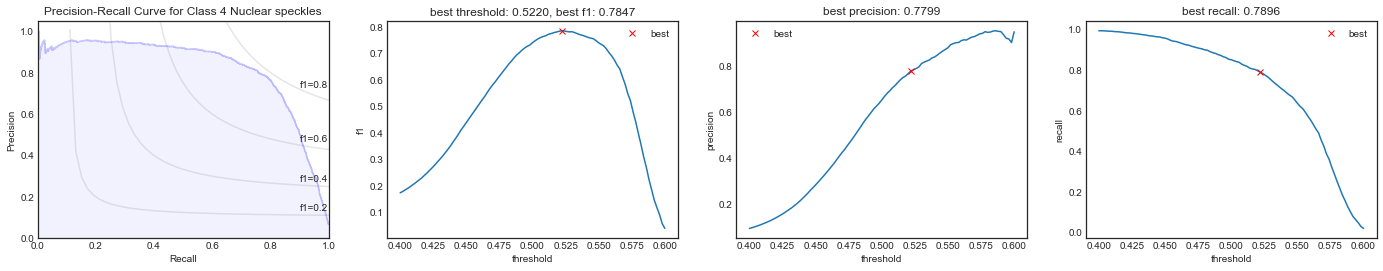

<Figure size 432x288 with 0 Axes>

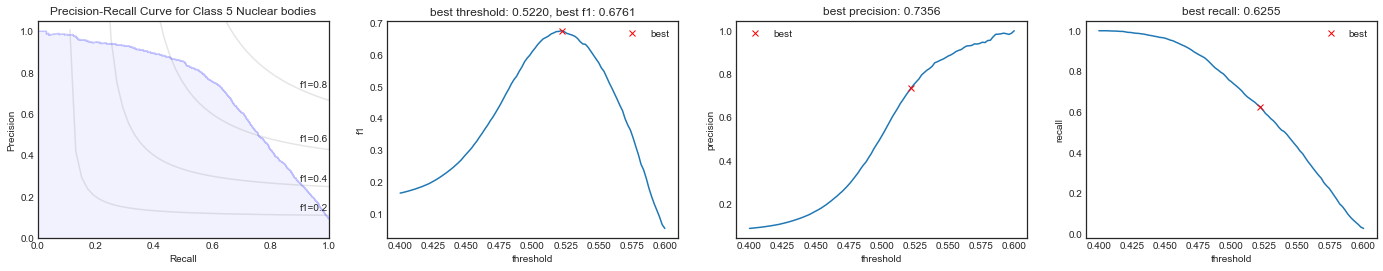

<Figure size 432x288 with 0 Axes>

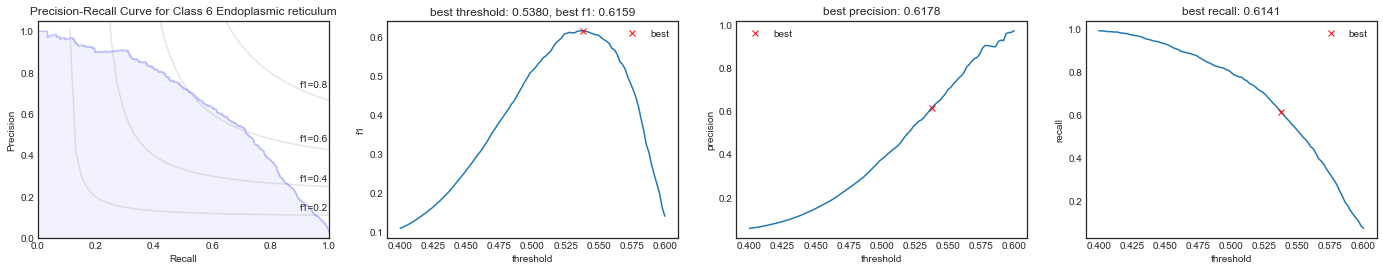

<Figure size 432x288 with 0 Axes>

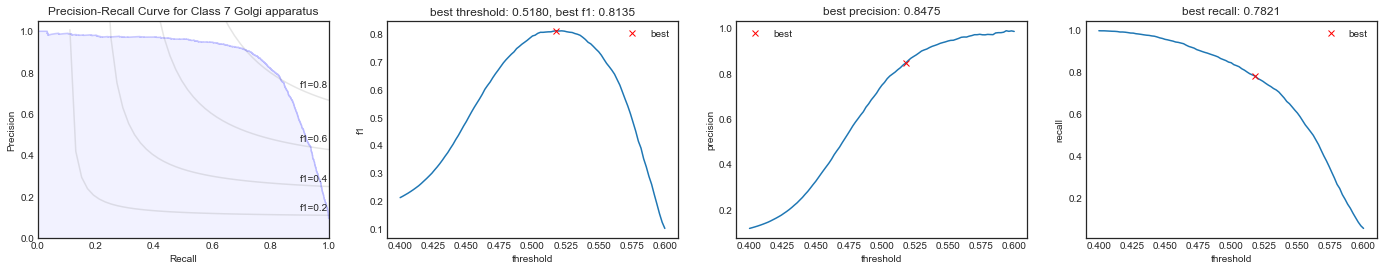

<Figure size 432x288 with 0 Axes>

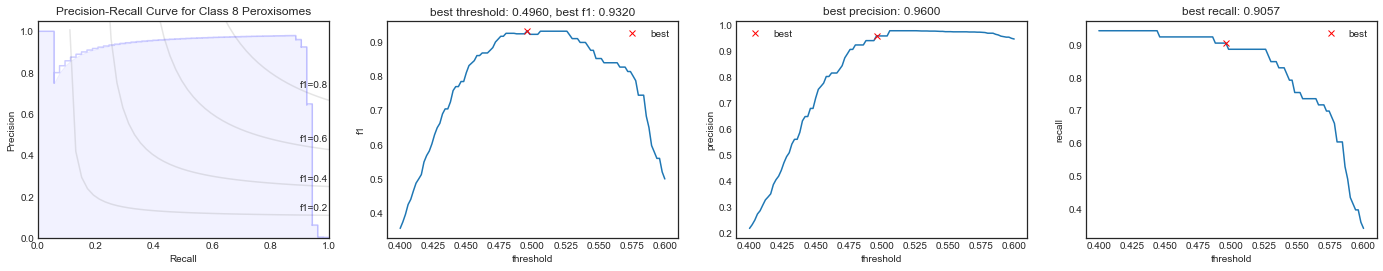

<Figure size 432x288 with 0 Axes>

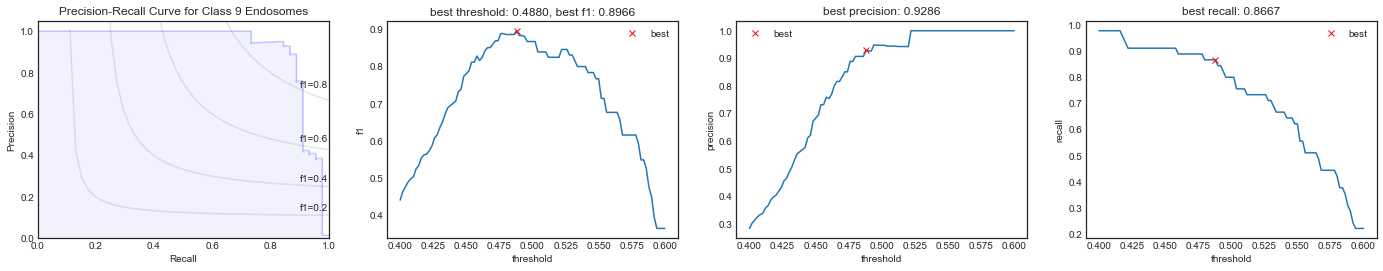

<Figure size 432x288 with 0 Axes>

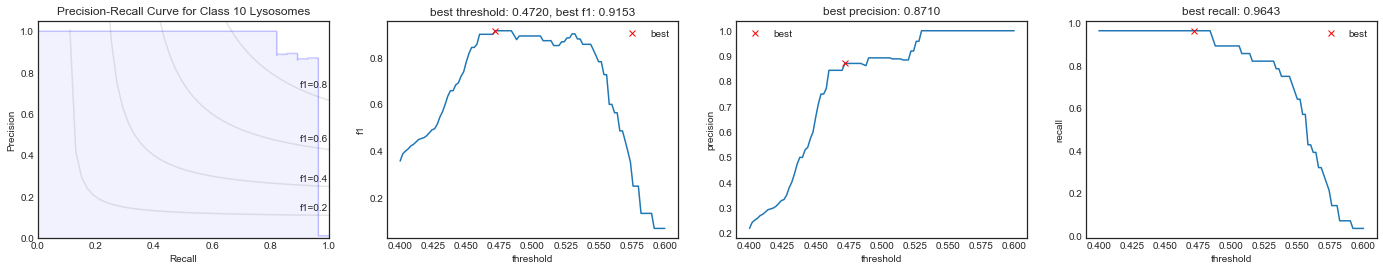

<Figure size 432x288 with 0 Axes>

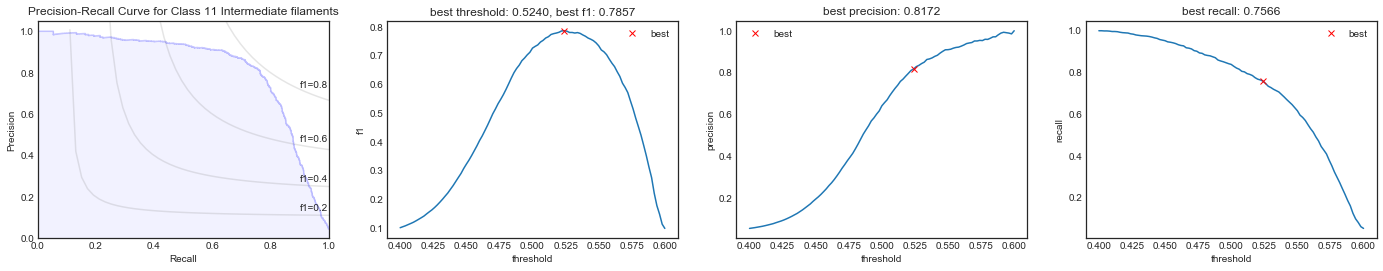

<Figure size 432x288 with 0 Axes>

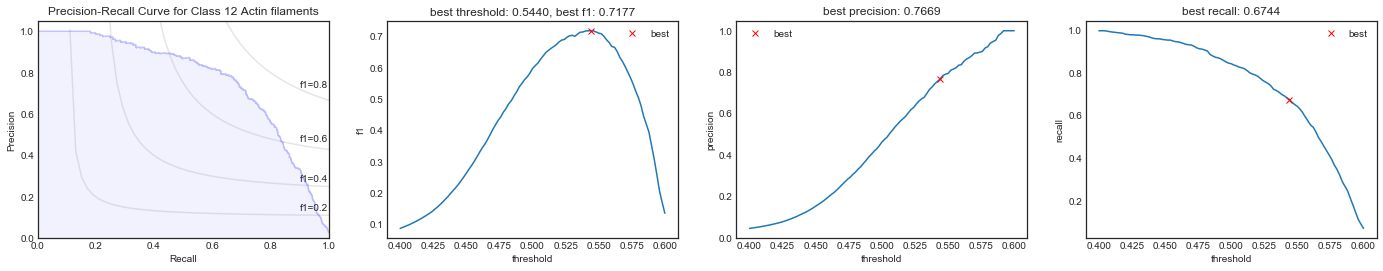

<Figure size 432x288 with 0 Axes>

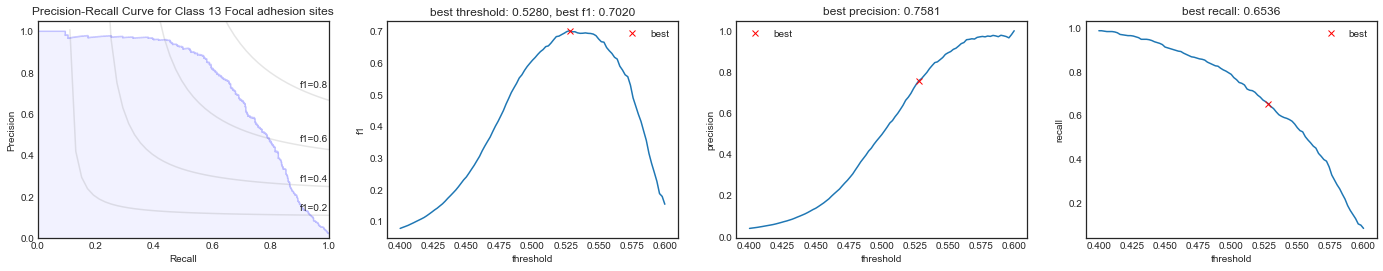

<Figure size 432x288 with 0 Axes>

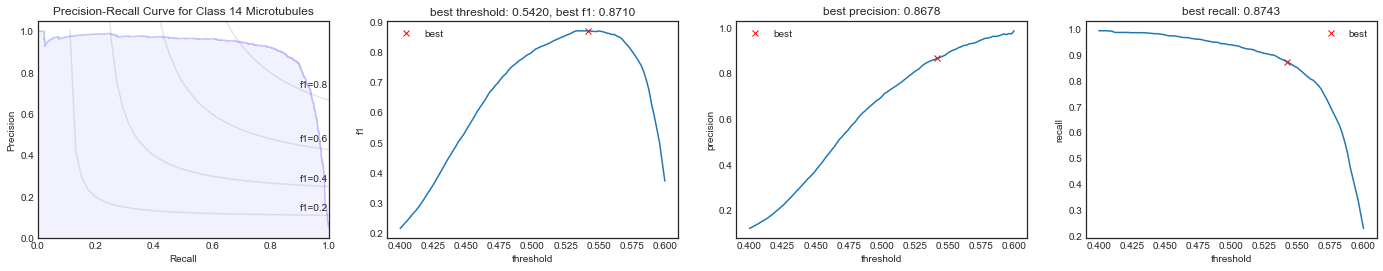

<Figure size 432x288 with 0 Axes>

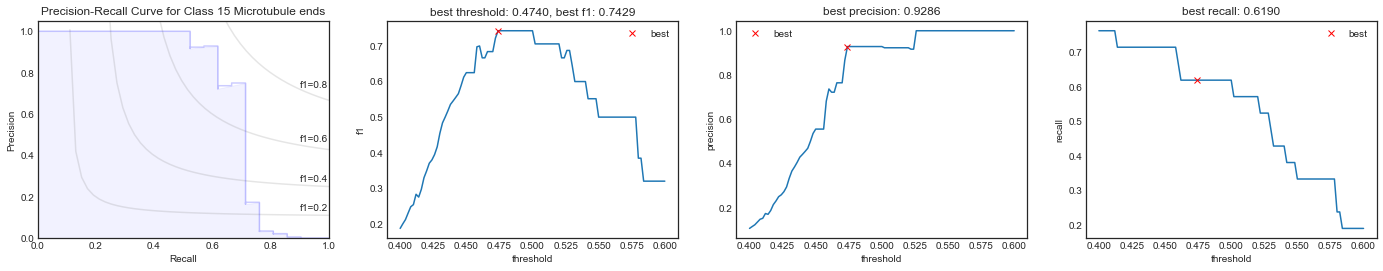

<Figure size 432x288 with 0 Axes>

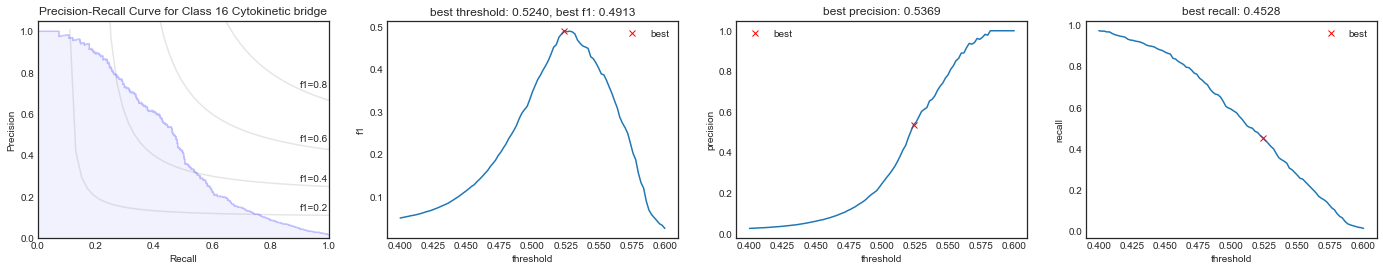

<Figure size 432x288 with 0 Axes>

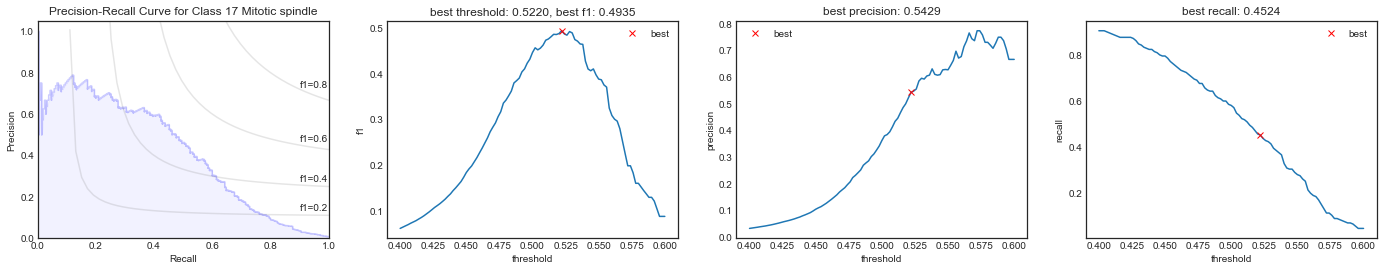

<Figure size 432x288 with 0 Axes>

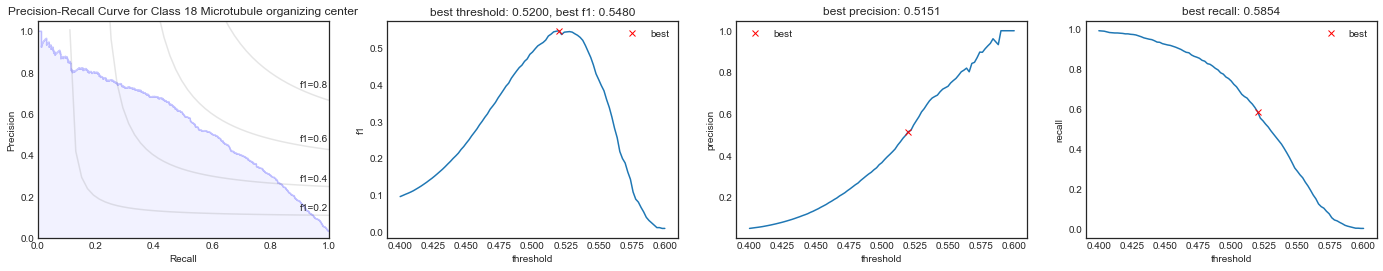

<Figure size 432x288 with 0 Axes>

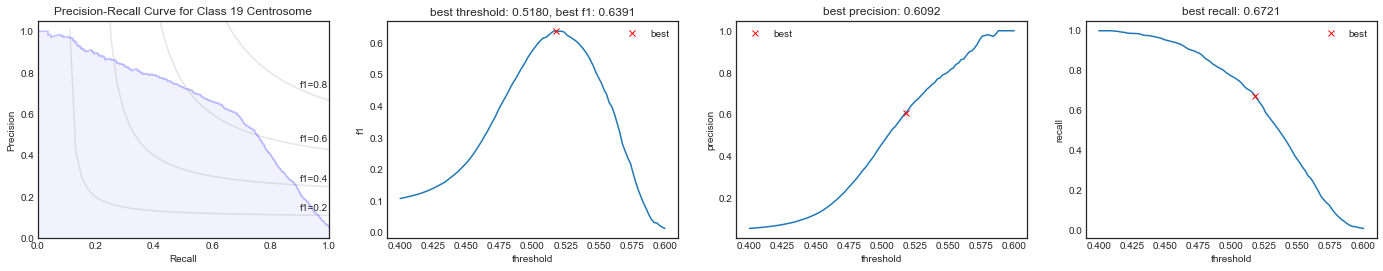

<Figure size 432x288 with 0 Axes>

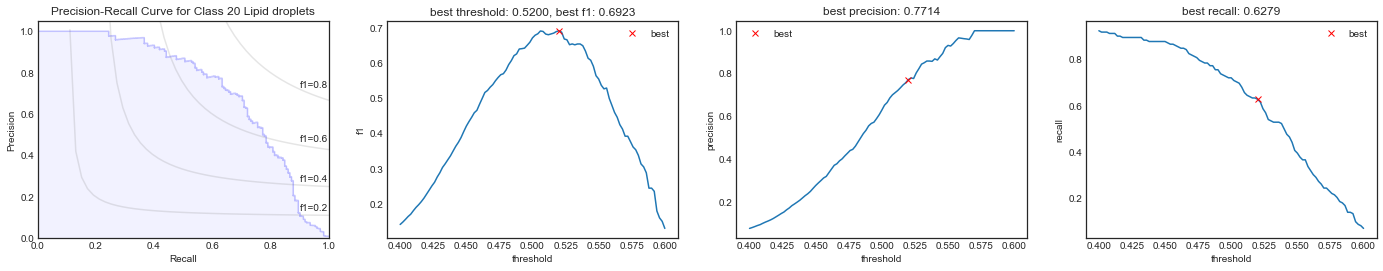

<Figure size 432x288 with 0 Axes>

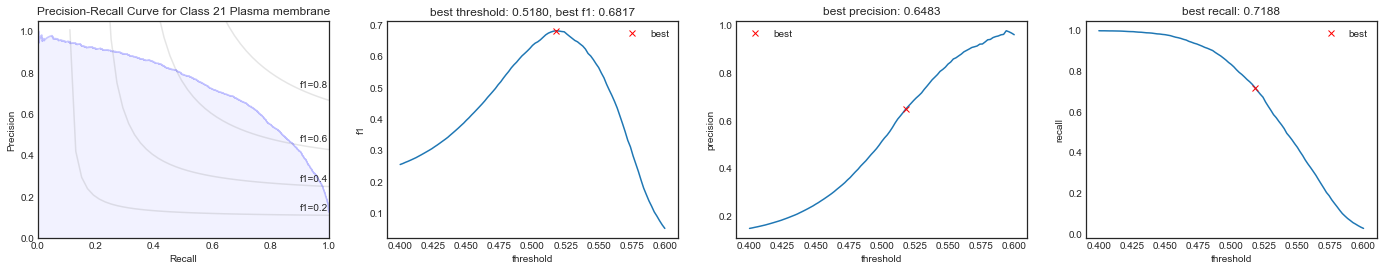

<Figure size 432x288 with 0 Axes>

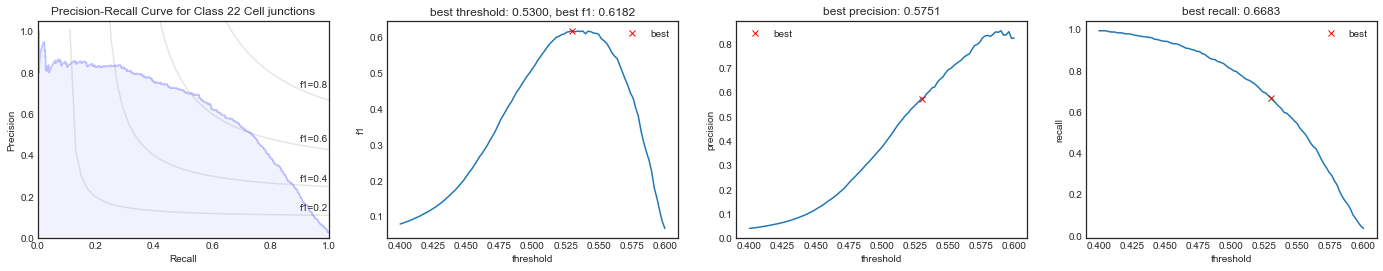

<Figure size 432x288 with 0 Axes>

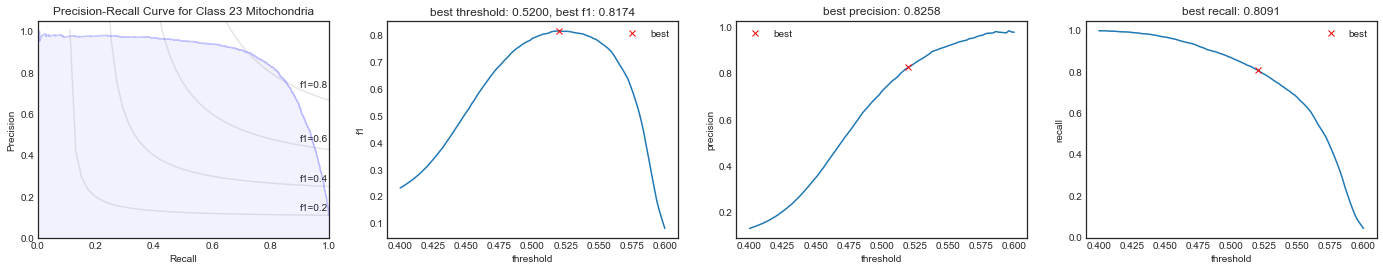

<Figure size 432x288 with 0 Axes>

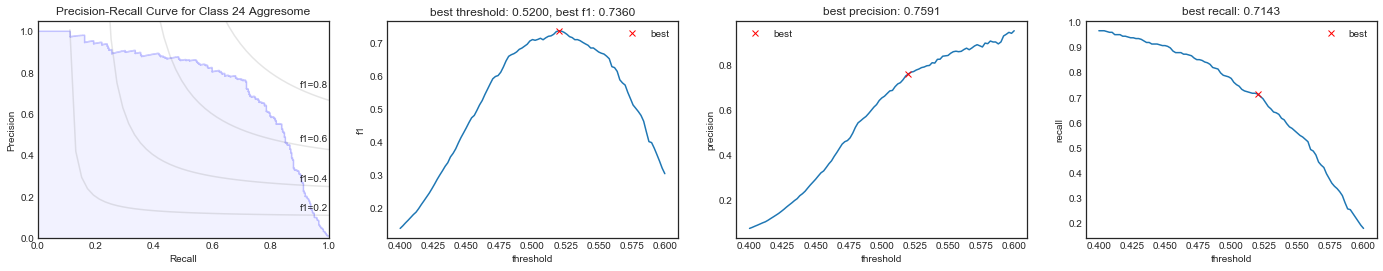

<Figure size 432x288 with 0 Axes>

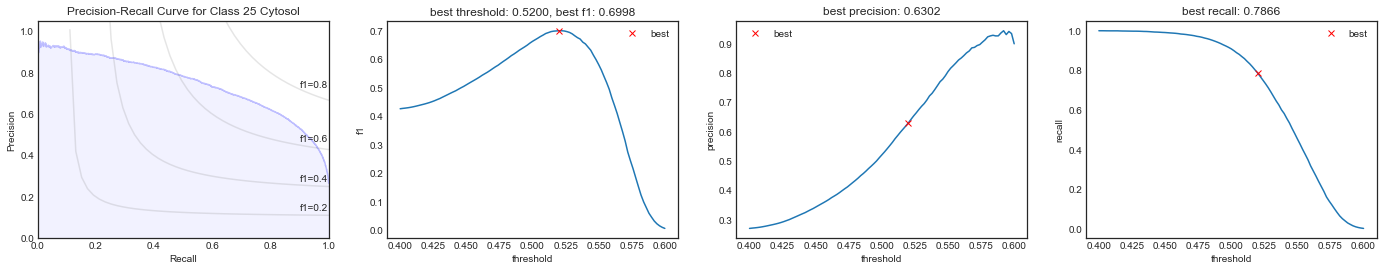

<Figure size 432x288 with 0 Axes>

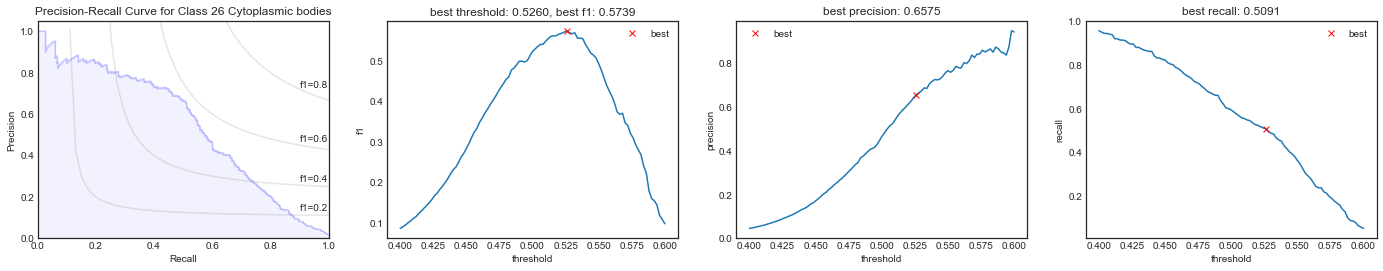

<Figure size 432x288 with 0 Axes>

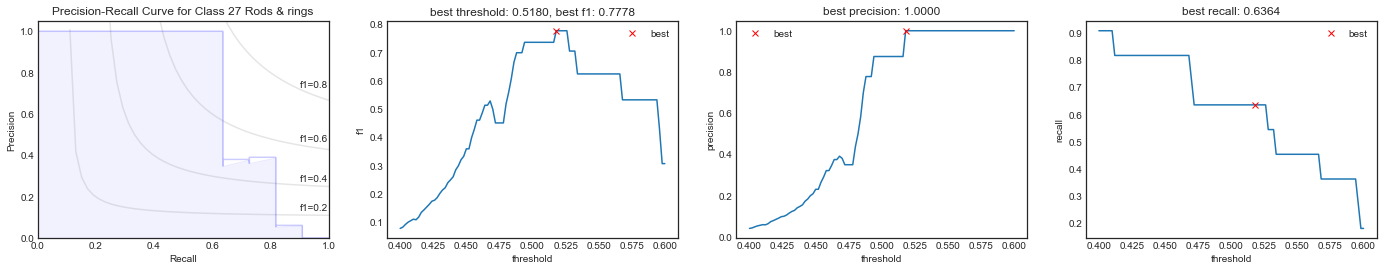

<Figure size 432x288 with 0 Axes>

In [258]:
n_classes = 28

# plot precision-recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()
f_scores = np.linspace(0.2, 0.8, num=4)
ta = []
fma = []

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y[:, i], bestEnsemble0[:, i])
    average_precision[i] = average_precision_score(y[:, i], bestEnsemble0[:, i])
    
#     plt.figure()
    
#     for f_score in f_scores:
#         xf = np.linspace(0.01, 1)
#         yf = f_score * xf / (2 * xf - f_score)
#         l, = plt.plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
#         plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

#     plt.step(recall[i], precision[i], color='b', alpha=0.2, where='post')
#     plt.fill_between(recall[i], precision[i], alpha=0.05, color='b')

#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
#     plt.title(LABEL_MAP[i])
    
    
    fig, axs = plt.subplots(1, 4, figsize=(24, 4))
    
    for f_score in f_scores:
        xf = np.linspace(0.01, 1)
        yf = f_score * xf / (2 * xf - f_score)
        l, = axs[0].plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
        axs[0].annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

    axs[0].step(recall[i], precision[i], color='b', alpha=0.2, where='post')
    axs[0].fill_between(recall[i], precision[i], alpha=0.05, color='b')

    axs[0].set_xlabel('Recall')
    axs[0].set_ylabel('Precision')
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_title('Precision-Recall Curve for Class ' + str(i) + ' ' + LABEL_MAP[i])
    
    
    thresholds = np.linspace(0.4, 0.6, 101)
    # for ranks
    # thresholds = np.linspace(0.8, 1.0, 101)
    fm = [f1_score(y[:,i], (bestEnsemble0[:,i] > t).astype(int)) for t in thresholds] 

    besti = np.argmax(fm)
    bestt = thresholds[besti]
    ta.append(bestt)
    bests = fm[besti] 
    fma.append(bests)
        
    axs[1].plot(thresholds, fm)
    axs[1].plot(bestt, bests, "xr", label="best")
    axs[1].set_xlabel("threshold")
    axs[1].set_ylabel("f1")
    axs[1].set_title("best threshold: %6.4f, best f1: %6.4f" % (bestt, bests))
    axs[1].legend()

    pm = [precision_score(y[:,i], (bestEnsemble0[:,i] > t).astype(int)) for t in thresholds] 
    bestsp = pm[besti] 
        
    axs[2].plot(thresholds, pm)
    axs[2].plot(bestt, bestsp, "xr", label="best")
    axs[2].set_xlabel("threshold")
    axs[2].set_ylabel("precision")
    axs[2].set_title("best precision: %6.4f" % (bestsp))
    axs[2].legend()
    
    rm = [recall_score(y[:,i], (bestEnsemble0[:,i] > t).astype(int)) for t in thresholds] 
    bestsr = rm[besti] 
        
    axs[3].plot(thresholds, rm)
    axs[3].plot(bestt, bestsr, "xr", label="best")
    axs[3].set_xlabel("threshold")
    axs[3].set_ylabel("recall")
    axs[3].set_title("best recall: %6.4f" % (bestsr))
    axs[3].legend()
    
    plt.show()
    plt.gcf().clear()

In [259]:
np.mean(fma)

0.7299754447250082

In [260]:
# error analysis
from sklearn.metrics import confusion_matrix

cm = [confusion_matrix(y[:,i], (bestEnsemble0[:,i]  > th[i]).astype(int)) \
       for i in range(y.shape[1])]
pma = [precision_score(y[:,i], (bestEnsemble0[:,i]  > th[i]).astype(int)) \
       for i in range(y.shape[1])]
rma = [recall_score(y[:,i], (bestEnsemble0[:,i]  > th[i]).astype(int)) \
       for i in range(y.shape[1])]

print('macro f1','%6.4f' % np.mean(fma))
print()

# sort from worst to best
order = np.array(fma).argsort()
ymean = np.mean(y,axis=0)

for i in range(y.shape[1]):
    oi = order[i]
    print('class', '%2d' % oi,'  prop', '%6.4f' % ymean[oi], 
                     '  f1', '%6.4f' % fma[oi],
                     '  precision', '%6.4f' % pma[oi],
                     '  recall', '%6.4f' % rma[oi],
                     '  ', LABEL_MAP[oi])
    print(cm[oi])
    print()

macro f1 0.7300

class 16   prop 0.0171   f1 0.4913   precision 0.5363   recall 0.4604    Cytokinetic bridge
[[30331   211]
 [  286   244]]

class 17   prop 0.0068   f1 0.4935   precision 0.5491   recall 0.4524    Mitotic spindle
[[30784    78]
 [  115    95]]

class 18   prop 0.0290   f1 0.5480   precision 0.4986   recall 0.6109    Microtubule organizing center
[[29616   554]
 [  351   551]]

class 26   prop 0.0106   f1 0.5739   precision 0.6601   recall 0.5091    Cytoplasmic bodies
[[30658    86]
 [  161   167]]

class  6   prop 0.0324   f1 0.6159   precision 0.6236   recall 0.6131    Endoplasmic reticulum
[[29691   373]
 [  390   618]]

class 22   prop 0.0258   f1 0.6182   precision 0.5784   recall 0.6671    Cell junctions
[[29880   390]
 [  267   535]]

class 19   prop 0.0477   f1 0.6391   precision 0.6077   recall 0.6815    Centrosome
[[28938   652]
 [  472  1010]]

class  5   prop 0.0809   f1 0.6761   precision 0.7271   recall 0.6319    Nuclear bodies
[[27963   596]
 [  925  1588

In [261]:
# confusion matrix of true val with single label
true_list = []
pred_list = []
for i, yi in enumerate(y):
#     img, y = db_val[i]

    true = np.nonzero(yi)[0]
    if len(true) > 1: continue
    
    pred = np.nonzero((bestEnsemble[i] > threshold_best).astype(int))[0]
    if len(pred)==0: pred = np.array([28])
    # replace empty with max prob
    # if len(pred)==0: pred = [np.argmax(vlsp[i])]
    for j in range(len(pred)):
        true_list.append(true[0])
        pred_list.append(pred[j])
    
print(y.shape[0],len(true_list),len(pred_list))

true = np.array(true_list)
pred = np.array(pred_list)
print(true.shape,true[:5])

np.set_printoptions(linewidth=250)
cm = confusion_matrix(true,pred)
print(cm)

31072 35759 35759
(35759,) [5 5 5 5 1]
[[2373   96  254  116  347  759    6   88    0    0    0   21   16   31   19  267   37   78  247    7  238   96   78   18 1115   45    0    3]
 [ 163  268   14    0    0    3   14    2    0    0    0    1    2    0    0    0    0    2    1    0    4    1    1    0   80    0    0    0]
 [ 436    5  737  153   18   41    3   18    0    0    0    9    9    1   13   27    3   23   16    1   41   16   28    0  234    3    0    7]
 [ 272    7  286  597   12   70   22   10    0    0    0    5    1    0    0    3    2    0    4    0   19    7   17    0  160    1    0    1]
 [ 479    3   52   36  986  102    1   22    0    0    0    6    5    7    4    9    0    9   25    0   42   14   24    2  225   21    1    3]
 [ 707   19   46  108  103  883    6   21    0    0    0    4   14    3    6   24    2   41   88    0   32   19   30   10  308   14    0    3]
 [ 100   50   17    4    3   13  545   13    0    0    0   33    3    2   25    8    3    5    8    3  


score_best 0.7175365717872181
threshold_best 0.52



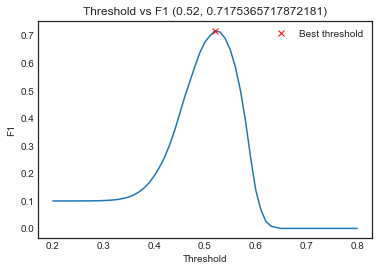

               mod   mean_f1
17     resnet_u101  0.724194
16      resnet_u56  0.723808
15      resnet_u31  0.723715
13      resnet_q27  0.723542
10         iv3_q12  0.723206
12      resnet_q26  0.721738
11         iv3_u11  0.721539
14      resnet_u25  0.721074
2       resnet_q24  0.720703
0          iv3_q11  0.720690
1         irv2_q10  0.720648
8           bni_q0  0.720299
19          bni_u1  0.720273
4       resnet_q40  0.720224
3       resnet_q25  0.720162
9           bni_q1  0.719513
18         gap_u14  0.718895
5          gap_q12  0.716194
6          nas_q11  0.715334
7   se_resnext_q26  0.715219


<Figure size 432x288 with 0 Axes>

In [262]:
# tb = table(rez$index[1:bestStep])
# names(tb) = names(vp)[(offset+1):ncol(vp)][as.integer(names(table(rez$index[1:bestStep])))]

# if (intercept!=0) {
#   tb["Intercept"] = intercept
# }

# print(tb[order(-tb)])
# print(single[order(-single[,2]),][1:min(nrow(single),40),])

# # plot hillclimbing
# ggplot(data=rez, aes(x=step, y=score)) + 
#   geom_line(size=.75) + geom_point()  


# replace empty predictions with class having max probability
def tmax1(vlsp, t):
    rez = (vlsp > t).astype(int)
    rezm = np.sum(rez,axis=1)
    z = np.where(rezm==0)[0]
    for i in z:
        rez[i,np.argmax(vlsp[i])] = 1
    return rez
        
# compute best threshold for computed ensemble
thresholds = np.linspace(0.2, 0.8, 61)
# thresholds = np.linspace(-2, 2, 41)
# thresholds = np.linspace(-0.2, 0.2, 41)

scores = np.array([f1_score(y, np.int32(bestEnsemble > threshold),
                        average='macro') for threshold in thresholds])

# scores = np.array([f1_score(y, tmax1(bestEnsemble, threshold),
#                         average='macro') for threshold in thresholds])


# ious = np.array([iou_metric_batch(train_df.masks, np.int32(bestEnsemble > threshold), \
#                                   pred_eps=pred_eps) for threshold in thresholds])

# threshold_best_index = np.argmax(ious[9:-10]) + 9
threshold_best_index = np.argmax(scores)
score_best = scores[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
print('')
print('score_best',score_best)
print('threshold_best',threshold_best)
print('')

plt.plot(thresholds, scores)
plt.plot(threshold_best, score_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title("Threshold vs F1 ({}, {})".format(threshold_best, score_best))
plt.legend()
plt.show()
plt.gcf().clear()

single['mean_'+metric] = single.iloc[:,1:].mean(axis=1)
single.sort_values('mean_'+metric,ascending=False,inplace=True)
print(single.loc[:,['mod','mean_'+metric]])

In [263]:
print(y.shape)
yis = np.array([yi for yi in y if len(np.nonzero(yi)[0])==1 ])
print(yis.shape)
yism = np.mean(yis,axis=0)


(31072, 28)
(15126, 28)


(-0.028576243238916825, 0.4436122904074585)

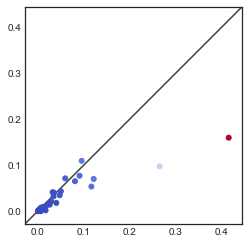

In [264]:
c = ymean**2 + yism**2

fig, ax = plt.subplots()
ax.scatter(ymean, yism, s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
# fig.savefig('/Users/paul/Desktop/so.png', dpi=300)



hillclimbing for class 0 Nucleoplasm

model 0 f1 0.8240 iv3_q11
model 1 f1 0.8062 irv2_q10
model 2 f1 0.8133 resnet_q24
model 3 f1 0.8094 resnet_q25
model 4 f1 0.8066 resnet_q40
model 5 f1 0.8016 gap_q12
model 6 f1 0.7906 nas_q11
model 7 f1 0.7834 se_resnext_q26
model 8 f1 0.7994 bni_q0
model 9 f1 0.8016 bni_q1
model 10 f1 0.8239 iv3_q12
model 11 f1 0.8149 iv3_u11
model 12 f1 0.7864 resnet_q26
model 13 f1 0.8220 resnet_q27
model 14 f1 0.8119 resnet_u25
model 15 f1 0.7987 resnet_u31
model 16 f1 0.8253 resnet_u56
model 17 f1 0.8230 resnet_u101
model 18 f1 0.8108 gap_u14
model 19 f1 0.8080 bni_u1
step = 0    f1 = 0.8253   name = resnet_u56
step = 1    f1 = 0.8366   name = resnet_q27
step = 2    f1 = 0.8391   name = iv3_q11
step = 3    f1 = 0.8383   name = resnet_u31
step = 4    f1 = 0.8391   name = resnet_q27
step = 5    f1 = 0.8393   name = resnet_u101
step = 6    f1 = 0.8398   name = resnet_u31
step = 7    f1 = 0.8400   name = resnet_q27
step = 8    f1 = 0.8393   name = resnet_u25
ste

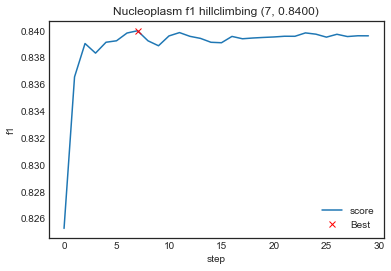

   step  midx     score          mod      f1_0
0     0    16  0.825270   resnet_u56  0.825270
1     1    13  0.836564   resnet_q27  0.821979
2     2     0  0.839054      iv3_q11  0.823961
3     3    15  0.838338   resnet_u31  0.798709
4     4    13  0.839149   resnet_q27  0.821979
5     5    17  0.839257  resnet_u101  0.823031
6     6    15  0.839836   resnet_u31  0.798709
7     7    13  0.840006   resnet_q27  0.821979

      weight          mod      f1_0
midx                               
0          1      iv3_q11  0.823961
13         3   resnet_q27  0.821979
15         2   resnet_u31  0.798709
16         1   resnet_u56  0.825270
17         1  resnet_u101  0.823031


hillclimbing for class 1 Nuclear membrane

model 0 f1 0.8284 iv3_q11
model 1 f1 0.8162 irv2_q10
model 2 f1 0.8175 resnet_q24
model 3 f1 0.8208 resnet_q25
model 4 f1 0.8089 resnet_q40
model 5 f1 0.8266 gap_q12
model 6 f1 0.7610 nas_q11
model 7 f1 0.7909 se_resnext_q26
model 8 f1 0.8065 bni_q0
model 9 f1 0.7956 bni_q1
mode

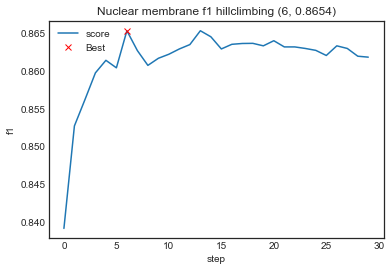

   step  midx     score          mod      f1_0
0     0    16  0.839155   resnet_u56  0.839155
1     1    14  0.852744   resnet_u25  0.828900
2     2    15  0.856214   resnet_u31  0.795618
3     3    17  0.859776  resnet_u101  0.834521
4     4    14  0.861441   resnet_u25  0.828900
5     5    17  0.860447  resnet_u101  0.834521
6     6    13  0.865362   resnet_q27  0.824458

      weight          mod      f1_0
midx                               
13         1   resnet_q27  0.824458
14         2   resnet_u25  0.828900
15         1   resnet_u31  0.795618
16         1   resnet_u56  0.839155
17         2  resnet_u101  0.834521


hillclimbing for class 2 Nucleoli

model 0 f1 0.7612 iv3_q11
model 1 f1 0.7474 irv2_q10
model 2 f1 0.7455 resnet_q24
model 3 f1 0.7377 resnet_q25
model 4 f1 0.7289 resnet_q40
model 5 f1 0.7153 gap_q12
model 6 f1 0.6518 nas_q11
model 7 f1 0.6890 se_resnext_q26
model 8 f1 0.7317 bni_q0
model 9 f1 0.7306 bni_q1
model 10 f1 0.7679 iv3_q12
model 11 f1 0.7510 iv3_u11
model

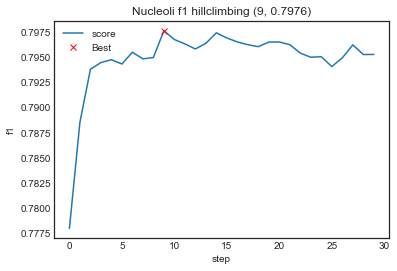

   step  midx     score          mod      f1_0
0     0    17  0.777980  resnet_u101  0.777980
1     1    10  0.788538      iv3_q12  0.767886
2     2    15  0.793816   resnet_u31  0.726289
3     3    16  0.794482   resnet_u56  0.777642
4     4    13  0.794768   resnet_q27  0.748578
5     5    10  0.794340      iv3_q12  0.767886
6     6    15  0.795509   resnet_u31  0.726289
7     7    10  0.794854      iv3_q12  0.767886
8     8    15  0.794984   resnet_u31  0.726289
9     9    17  0.797649  resnet_u101  0.777980

      weight          mod      f1_0
midx                               
10         3      iv3_q12  0.767886
13         1   resnet_q27  0.748578
15         3   resnet_u31  0.726289
16         1   resnet_u56  0.777642
17         2  resnet_u101  0.777980


hillclimbing for class 3 Nucleoli fibrillar center

model 0 f1 0.6299 iv3_q11
model 1 f1 0.5695 irv2_q10
model 2 f1 0.6103 resnet_q24
model 3 f1 0.6079 resnet_q25
model 4 f1 0.5827 resnet_q40
model 5 f1 0.5627 gap_q12
model 6 f1

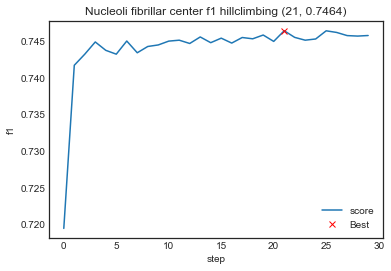

    step  midx     score          mod      f1_0
0      0    17  0.719476  resnet_u101  0.719476
1      1    15  0.741718   resnet_u31  0.683472
2      2    16  0.743230   resnet_u56  0.706152
3      3    15  0.744895   resnet_u31  0.683472
4      4    17  0.743754  resnet_u101  0.719476
5      5    16  0.743230   resnet_u56  0.706152
6      6    13  0.745022   resnet_q27  0.652389
7      7    15  0.743421   resnet_u31  0.683472
8      8    17  0.744277  resnet_u101  0.719476
9      9    13  0.744488   resnet_q27  0.652389
10    10    17  0.745010  resnet_u101  0.719476
11    11    10  0.745136      iv3_q12  0.653713
12    12    13  0.744688   resnet_q27  0.652389
13    13    15  0.745577   resnet_u31  0.683472
14    14    16  0.744797   resnet_u56  0.706152
15    15    15  0.745414   resnet_u31  0.683472
16    16    17  0.744743  resnet_u101  0.719476
17    17    16  0.745501   resnet_u56  0.706152
18    18    17  0.745326  resnet_u101  0.719476
19    19    13  0.745840   resnet_q27  0

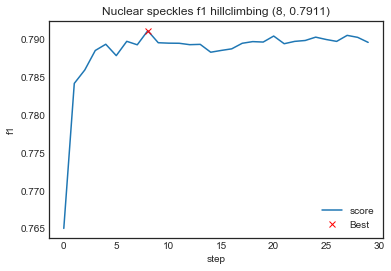

   step  midx     score         mod      f1_0
0     0    16  0.765019  resnet_u56  0.765019
1     1    15  0.784163  resnet_u31  0.726928
2     2    10  0.785934     iv3_q12  0.753005
3     3    16  0.788509  resnet_u56  0.765019
4     4    14  0.789330  resnet_u25  0.744395
5     5    13  0.787829  resnet_q27  0.745533
6     6    15  0.789716  resnet_u31  0.726928
7     7    13  0.789260  resnet_q27  0.745533
8     8    16  0.791114  resnet_u56  0.765019

      weight         mod      f1_0
midx                              
10         1     iv3_q12  0.753005
13         2  resnet_q27  0.745533
14         1  resnet_u25  0.744395
15         2  resnet_u31  0.726928
16         3  resnet_u56  0.765019


hillclimbing for class 5 Nuclear bodies

model 0 f1 0.5938 iv3_q11
model 1 f1 0.5503 irv2_q10
model 2 f1 0.5621 resnet_q24
model 3 f1 0.5638 resnet_q25
model 4 f1 0.5351 resnet_q40
model 5 f1 0.5227 gap_q12
model 6 f1 0.4064 nas_q11
model 7 f1 0.5045 se_resnext_q26
model 8 f1 0.5495 bni_q0
m

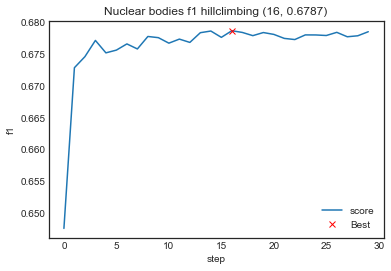

    step  midx     score          mod      f1_0
0      0    15  0.647579   resnet_u31  0.647579
1      1    16  0.672876   resnet_u56  0.639369
2      2    15  0.674615   resnet_u31  0.647579
3      3    13  0.677169   resnet_q27  0.586758
4      4    16  0.675214   resnet_u56  0.639369
5      5    15  0.675647   resnet_u31  0.647579
6      6    18  0.676621      gap_u14  0.588005
7      7    15  0.675829   resnet_u31  0.647579
8      8    15  0.677792   resnet_u31  0.647579
9      9    15  0.677605   resnet_u31  0.647579
10    10    11  0.676740      iv3_u11  0.602746
11    11    17  0.677378  resnet_u101  0.607957
12    12    15  0.676857   resnet_u31  0.647579
13    13    16  0.678388   resnet_u56  0.639369
14    14    15  0.678649   resnet_u31  0.647579
15    15    16  0.677654   resnet_u56  0.639369
16    16    13  0.678694   resnet_q27  0.586758

      weight          mod      f1_0
midx                               
11         1      iv3_u11  0.602746
13         2   resnet_q27  

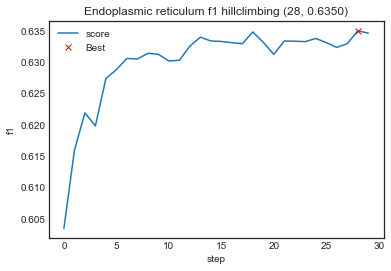

    step  midx     score          mod      f1_0
0      0    13  0.603448   resnet_q27  0.603448
1      1    10  0.615924      iv3_q12  0.584964
2      2    13  0.621898   resnet_q27  0.603448
3      3    16  0.619839   resnet_u56  0.587070
4      4    15  0.627390   resnet_u31  0.556006
5      5     2  0.628807   resnet_q24  0.568296
6      6     2  0.630603   resnet_q24  0.568296
7      7    13  0.630502   resnet_q27  0.603448
8      8     1  0.631417     irv2_q10  0.552657
9      9     2  0.631256   resnet_q24  0.568296
10    10    15  0.630193   resnet_u31  0.556006
11    11    10  0.630309      iv3_q12  0.584964
12    12    17  0.632558  resnet_u101  0.591089
13    13    12  0.633994   resnet_q26  0.559205
14    14    11  0.633385      iv3_u11  0.563611
15    15    17  0.633316  resnet_u101  0.591089
16    16    13  0.633108   resnet_q27  0.603448
17    17    17  0.632951  resnet_u101  0.591089
18    18     9  0.634823       bni_q1  0.555444
19    19     2  0.633161   resnet_q24  0

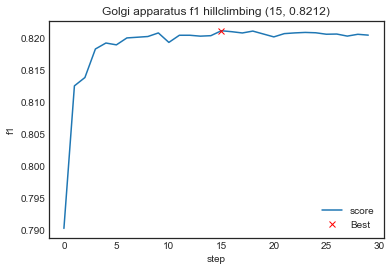

    step  midx     score          mod      f1_0
0      0    17  0.790326  resnet_u101  0.790326
1      1    13  0.812593   resnet_q27  0.776294
2      2    16  0.813890   resnet_u56  0.789542
3      3    15  0.818349   resnet_u31  0.774462
4      4    10  0.819282      iv3_q12  0.786957
5      5    17  0.818995  resnet_u101  0.790326
6      6    13  0.820078   resnet_q27  0.776294
7      7    13  0.820186   resnet_q27  0.776294
8      8    17  0.820298  resnet_u101  0.790326
9      9    15  0.820858   resnet_u31  0.774462
10    10    10  0.819378      iv3_q12  0.786957
11    11    17  0.820494  resnet_u101  0.790326
12    12    15  0.820494   resnet_u31  0.774462
13    13    16  0.820354   resnet_u56  0.789542
14    14    17  0.820429  resnet_u101  0.790326
15    15    15  0.821199   resnet_u31  0.774462

      weight          mod      f1_0
midx                               
10         2      iv3_q12  0.786957
13         3   resnet_q27  0.776294
15         4   resnet_u31  0.774462
16 

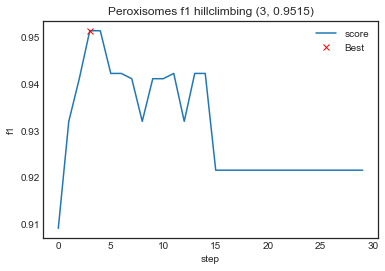

   step  midx     score          mod      f1_0
0     0    16  0.909091   resnet_u56  0.909091
1     1    15  0.932039   resnet_u31  0.871287
2     2    17  0.941176  resnet_u101  0.909091
3     3    15  0.951456   resnet_u31  0.871287

      weight          mod      f1_0
midx                               
15         2   resnet_u31  0.871287
16         1   resnet_u56  0.909091
17         1  resnet_u101  0.909091


hillclimbing for class 9 Endosomes

model 0 f1 0.6250 iv3_q11
model 1 f1 0.6667 irv2_q10
model 2 f1 0.5974 resnet_q24
model 3 f1 0.6067 resnet_q25
model 4 f1 0.6588 resnet_q40
model 5 f1 0.7027 gap_q12
model 6 f1 0.5618 nas_q11
model 7 f1 0.6761 se_resnext_q26
model 8 f1 0.7317 bni_q0
model 9 f1 0.6316 bni_q1
model 10 f1 0.5915 iv3_q12
model 11 f1 0.7619 iv3_u11
model 12 f1 0.6747 resnet_q26
model 13 f1 0.7250 resnet_q27
model 14 f1 0.7609 resnet_u25
model 15 f1 0.8636 resnet_u31
model 16 f1 0.8395 resnet_u56
model 17 f1 0.8182 resnet_u101
model 18 f1 0.7368 gap_u14
model 19 

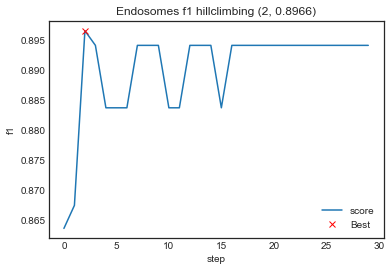

   step  midx     score         mod      f1_0
0     0    15  0.863636  resnet_u31  0.863636
1     1    16  0.867470  resnet_u56  0.839506
2     2     3  0.896552  resnet_q25  0.606742

      weight         mod      f1_0
midx                              
3          1  resnet_q25  0.606742
15         1  resnet_u31  0.863636
16         1  resnet_u56  0.839506


hillclimbing for class 10 Lysosomes

model 0 f1 0.6400 iv3_q11
model 1 f1 0.6786 irv2_q10
model 2 f1 0.6154 resnet_q24
model 3 f1 0.5429 resnet_q25
model 4 f1 0.5185 resnet_q40
model 5 f1 0.6512 gap_q12
model 6 f1 0.5263 nas_q11
model 7 f1 0.5500 se_resnext_q26
model 8 f1 0.7170 bni_q0
model 9 f1 0.5667 bni_q1
model 10 f1 0.5714 iv3_q12
model 11 f1 0.7857 iv3_u11
model 12 f1 0.7200 resnet_q26
model 13 f1 0.7660 resnet_q27
model 14 f1 0.8364 resnet_u25
model 15 f1 0.8627 resnet_u31
model 16 f1 0.8929 resnet_u56
model 17 f1 0.9286 resnet_u101
model 18 f1 0.7018 gap_u14
model 19 f1 0.8070 bni_u1
step = 0    f1 = 0.9286   name = resne

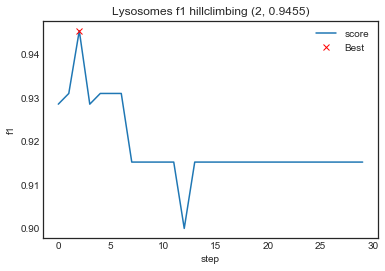

   step  midx     score          mod      f1_0
0     0    17  0.928571  resnet_u101  0.928571
1     1    15  0.931034   resnet_u31  0.862745
2     2     0  0.945455      iv3_q11  0.640000

      weight          mod      f1_0
midx                               
0          1      iv3_q11  0.640000
15         1   resnet_u31  0.862745
17         1  resnet_u101  0.928571


hillclimbing for class 11 Intermediate filaments

model 0 f1 0.7348 iv3_q11
model 1 f1 0.7158 irv2_q10
model 2 f1 0.7248 resnet_q24
model 3 f1 0.6882 resnet_q25
model 4 f1 0.7252 resnet_q40
model 5 f1 0.7139 gap_q12
model 6 f1 0.5888 nas_q11
model 7 f1 0.6815 se_resnext_q26
model 8 f1 0.7025 bni_q0
model 9 f1 0.6915 bni_q1
model 10 f1 0.7526 iv3_q12
model 11 f1 0.7271 iv3_u11
model 12 f1 0.6586 resnet_q26
model 13 f1 0.7063 resnet_q27
model 14 f1 0.7068 resnet_u25
model 15 f1 0.6747 resnet_u31
model 16 f1 0.7387 resnet_u56
model 17 f1 0.7504 resnet_u101
model 18 f1 0.7177 gap_u14
model 19 f1 0.7128 bni_u1
step = 0    f1 =

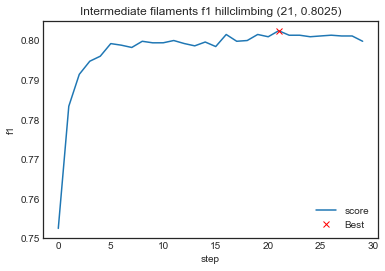

    step  midx     score          mod      f1_0
0      0    10  0.752552      iv3_q12  0.752552
1      1    16  0.783397   resnet_u56  0.738713
2      2    13  0.791460   resnet_q27  0.706280
3      3     2  0.794773   resnet_q24  0.724758
4      4     4  0.796040   resnet_q40  0.725215
5      5    16  0.799222   resnet_u56  0.738713
6      6     8  0.798825       bni_q0  0.702467
7      7    16  0.798246   resnet_u56  0.738713
8      8    12  0.799808   resnet_q26  0.658627
9      9    10  0.799419      iv3_q12  0.752552
10    10     1  0.799428     irv2_q10  0.715850
11    11    11  0.800000      iv3_u11  0.727104
12    12    17  0.799239  resnet_u101  0.750368
13    13     6  0.798654      nas_q11  0.588823
14    14     9  0.799620       bni_q1  0.691515
15    15    16  0.798479   resnet_u56  0.738713
16    16    10  0.801523      iv3_q12  0.752552
17    17    11  0.799810      iv3_u11  0.727104
18    18     4  0.800000   resnet_q40  0.725215
19    19    16  0.801527   resnet_u56  0

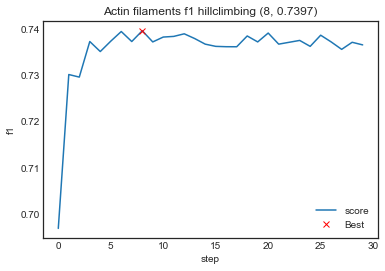

   step  midx     score          mod      f1_0
0     0    16  0.696859   resnet_u56  0.696859
1     1    14  0.730183   resnet_u25  0.670134
2     2    17  0.729627  resnet_u101  0.673851
3     3    11  0.737327      iv3_u11  0.673668
4     4    11  0.735160      iv3_u11  0.673668
5     5    16  0.737405   resnet_u56  0.696859
6     6    14  0.739496   resnet_u25  0.670134
7     7    17  0.737327  resnet_u101  0.673851
8     8    11  0.739663      iv3_u11  0.673668

      weight          mod      f1_0
midx                               
11         3      iv3_u11  0.673668
14         2   resnet_u25  0.670134
16         2   resnet_u56  0.696859
17         2  resnet_u101  0.673851


hillclimbing for class 13 Focal adhesion sites

model 0 f1 0.6204 iv3_q11
model 1 f1 0.6107 irv2_q10
model 2 f1 0.6190 resnet_q24
model 3 f1 0.6225 resnet_q25
model 4 f1 0.6224 resnet_q40
model 5 f1 0.6032 gap_q12
model 6 f1 0.4559 nas_q11
model 7 f1 0.5757 se_resnext_q26
model 8 f1 0.6106 bni_q0
model 9 f1 0.

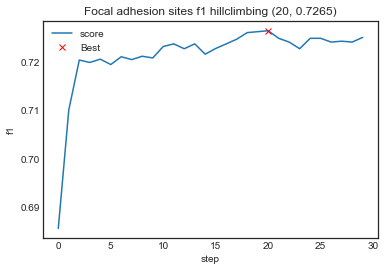

    step  midx     score          mod      f1_0
0      0    16  0.685547   resnet_u56  0.685547
1      1    17  0.710084  resnet_u101  0.676190
2      2    11  0.720419      iv3_u11  0.596050
3      3    14  0.719915   resnet_u25  0.639843
4      4    13  0.720604   resnet_q27  0.660732
5      5    17  0.719486  resnet_u101  0.676190
6      6    15  0.721103   resnet_u31  0.567474
7      7    16  0.720510   resnet_u56  0.685547
8      8     6  0.721206      nas_q11  0.455868
9      9    16  0.720856   resnet_u56  0.685547
10    10    17  0.723224  resnet_u101  0.676190
11    11     0  0.723769      iv3_q11  0.620408
12    12    16  0.722762   resnet_u56  0.685547
13    13     5  0.723769      gap_q12  0.603206
14    14    14  0.721627   resnet_u25  0.639843
15    15    17  0.722814  resnet_u101  0.676190
16    16     6  0.723769      nas_q11  0.455868
17    17    16  0.724731   resnet_u56  0.685547
18    18    17  0.726101  resnet_u101  0.676190
19    19    14  0.726293   resnet_u25  0

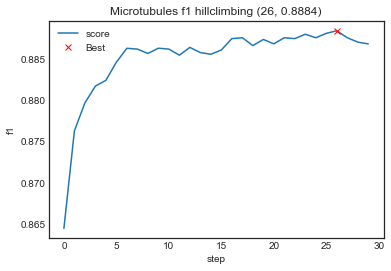

    step  midx     score          mod      f1_0
0      0     2  0.864528   resnet_q24  0.864528
1      1    17  0.876298  resnet_u101  0.857408
2      2    10  0.879660      iv3_q12  0.864209
3      3    16  0.881690   resnet_u56  0.859953
4      4    18  0.882381      gap_u14  0.845484
5      5    17  0.884579  resnet_u101  0.857408
6      6     3  0.886245   resnet_q25  0.852043
7      7    13  0.886148   resnet_q27  0.862857
8      8    17  0.885619  resnet_u101  0.857408
9      9    16  0.886256   resnet_u56  0.859953
10    10    13  0.886148   resnet_q27  0.862857
11    11    13  0.885417   resnet_q27  0.862857
12    12    17  0.886353  resnet_u101  0.857408
13    13    18  0.885728      gap_u14  0.845484
14    14    13  0.885525   resnet_q27  0.862857
15    15    10  0.886040      iv3_q12  0.864209
16    16    17  0.887411  resnet_u101  0.857408
17    17    16  0.887518   resnet_u56  0.859953
18    18    16  0.886569   resnet_u56  0.859953
19    19    18  0.887311      gap_u14  0

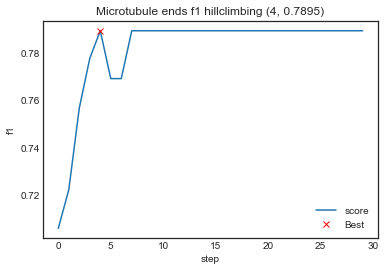

   step  midx     score          mod      f1_0
0     0    10  0.705882      iv3_q12  0.705882
1     1    15  0.722222   resnet_u31  0.666667
2     2    17  0.756757  resnet_u101  0.628571
3     3    15  0.777778   resnet_u31  0.666667
4     4     6  0.789474      nas_q11  0.416667

      weight          mod      f1_0
midx                               
6          1      nas_q11  0.416667
10         1      iv3_q12  0.705882
15         2   resnet_u31  0.666667
17         1  resnet_u101  0.628571


hillclimbing for class 16 Cytokinetic bridge

model 0 f1 0.4096 iv3_q11
model 1 f1 0.3588 irv2_q10
model 2 f1 0.3352 resnet_q24
model 3 f1 0.3216 resnet_q25
model 4 f1 0.2831 resnet_q40
model 5 f1 0.2509 gap_q12
model 6 f1 0.2089 nas_q11
model 7 f1 0.3233 se_resnext_q26
model 8 f1 0.2990 bni_q0
model 9 f1 0.3193 bni_q1
model 10 f1 0.4487 iv3_q12
model 11 f1 0.3304 iv3_u11
model 12 f1 0.3148 resnet_q26
model 13 f1 0.4071 resnet_q27
model 14 f1 0.2881 resnet_u25
model 15 f1 0.2694 resnet_u31
mode

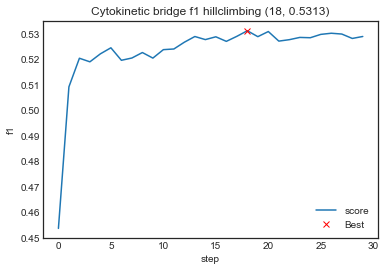

    step  midx     score             mod      f1_0
0      0    17  0.453682     resnet_u101  0.453682
1      1    10  0.509259         iv3_q12  0.448718
2      2    16  0.520487      resnet_u56  0.431325
3      3    10  0.519084         iv3_q12  0.448718
4      4    15  0.522222      resnet_u31  0.269366
5      5     6  0.524590         nas_q11  0.208877
6      6     7  0.519685  se_resnext_q26  0.323314
7      7    16  0.520578      resnet_u56  0.431325
8      8    10  0.522727         iv3_q12  0.448718
9      9    19  0.520548          bni_u1  0.313433
10    10    16  0.523862      resnet_u56  0.431325
11    11    17  0.524123     resnet_u101  0.453682
12    12     1  0.526786        irv2_q10  0.358779
13    13    12  0.529018      resnet_q26  0.314774
14    14    16  0.527808      resnet_u56  0.431325
15    15     1  0.528908        irv2_q10  0.358779
16    16    10  0.527115         iv3_q12  0.448718
17    17    17  0.529089     resnet_u101  0.453682
18    18     1  0.531284       

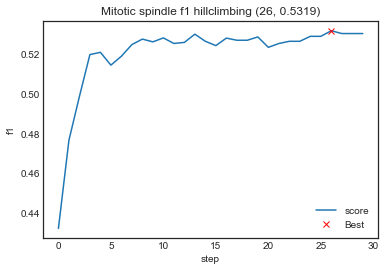

    step  midx     score          mod      f1_0
0      0    13  0.432314   resnet_q27  0.432314
1      1    15  0.476712   resnet_u31  0.336245
2      2    16  0.498778   resnet_u56  0.423256
3      3     0  0.519894      iv3_q11  0.370892
4      4     3  0.521053   resnet_q25  0.389722
5      5    13  0.514589   resnet_q27  0.432314
6      6    16  0.519084   resnet_u56  0.423256
7      7    13  0.524934   resnet_q27  0.432314
8      8    12  0.527704   resnet_q26  0.386179
9      9     2  0.526316   resnet_q24  0.382979
10    10     1  0.528302     irv2_q10  0.315789
11    11     1  0.525510     irv2_q10  0.315789
12    12    10  0.526042      iv3_q12  0.410000
13    13    12  0.530184   resnet_q26  0.386179
14    14     2  0.526596   resnet_q24  0.382979
15    15    16  0.524422   resnet_u56  0.423256
16    16     1  0.528205     irv2_q10  0.315789
17    17     3  0.527132   resnet_q25  0.389722
18    18     3  0.527132   resnet_q25  0.389722
19    19     2  0.528796   resnet_q24  0

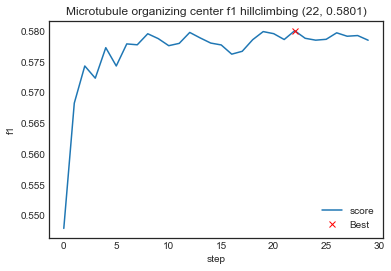

    step  midx     score         mod      f1_0
0      0    13  0.547903  resnet_q27  0.547903
1      1    15  0.568289  resnet_u31  0.495248
2      2    13  0.574332  resnet_q27  0.547903
3      3    13  0.572344  resnet_q27  0.547903
4      4    15  0.577309  resnet_u31  0.495248
5      5    13  0.574332  resnet_q27  0.547903
6      6    18  0.577922     gap_u14  0.442029
7      7    13  0.577778  resnet_q27  0.547903
8      8    13  0.579575  resnet_q27  0.547903
9      9    15  0.578782  resnet_u31  0.495248
10    10     0  0.577633     iv3_q11  0.462006
11    11    13  0.578010  resnet_q27  0.547903
12    12    13  0.579787  resnet_q27  0.547903
13    13    14  0.578891  resnet_u25  0.499133
14    14    13  0.578059  resnet_q27  0.547903
15    15    16  0.577754  resnet_u56  0.470855
16    16    15  0.576253  resnet_u31  0.495248
17    17    12  0.576720  resnet_q26  0.513955
18    18    13  0.578610  resnet_q27  0.547903
19    19    15  0.579926  resnet_u31  0.495248
20    20    1

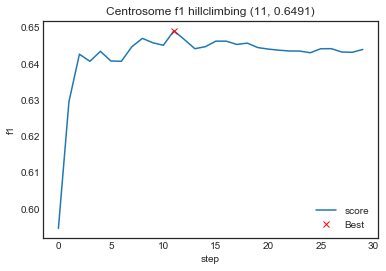

    step  midx     score          mod      f1_0
0      0    16  0.594595   resnet_u56  0.594595
1      1    15  0.629451   resnet_u31  0.587953
2      2    13  0.642602   resnet_q27  0.558743
3      3    10  0.640630      iv3_q12  0.569965
4      4    17  0.643395  resnet_u101  0.585256
5      5    18  0.640719      gap_u14  0.557121
6      6    15  0.640650   resnet_u31  0.587953
7      7    16  0.644667   resnet_u56  0.594595
8      8    15  0.646961   resnet_u31  0.587953
9      9    16  0.645743   resnet_u56  0.594595
10    10    15  0.645052   resnet_u31  0.587953
11    11    10  0.649059      iv3_q12  0.569965

      weight          mod      f1_0
midx                               
10         2      iv3_q12  0.569965
13         1   resnet_q27  0.558743
15         4   resnet_u31  0.587953
16         3   resnet_u56  0.594595
17         1  resnet_u101  0.585256
18         1      gap_u14  0.557121


hillclimbing for class 20 Lipid droplets

model 0 f1 0.5013 iv3_q11
model 1 f1 0.5074

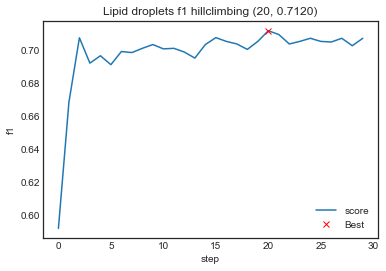

    step  midx     score         mod      f1_0
0      0    15  0.591900  resnet_u31  0.591900
1      1    16  0.668524  resnet_u56  0.591195
2      2    13  0.707692  resnet_q27  0.532637
3      3    14  0.692308  resnet_u25  0.529730
4      4    11  0.696774     iv3_u11  0.556575
5      5     2  0.691358  resnet_q24  0.569659
6      6    16  0.699346  resnet_u56  0.591195
7      7    15  0.698718  resnet_u31  0.591900
8      8     8  0.701299      bni_q0  0.537396
9      9    19  0.703583      bni_u1  0.492582
10    10    13  0.700965  resnet_q27  0.532637
11    11    19  0.701299      bni_u1  0.492582
12    12    12  0.699029  resnet_q26  0.550820
13    13    15  0.695364  resnet_u31  0.591900
14    14    16  0.703583  resnet_u56  0.591195
15    15    19  0.707792      bni_u1  0.492582
16    16     2  0.705502  resnet_q24  0.569659
17    17    13  0.703947  resnet_q27  0.532637
18    18    16  0.700637  resnet_u56  0.591195
19    19    15  0.705502  resnet_u31  0.591900
20    20     

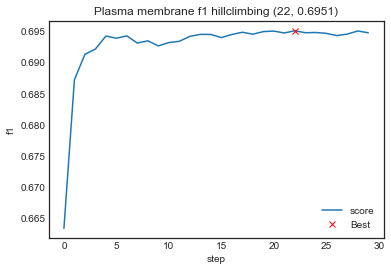

    step  midx     score          mod      f1_0
0      0    16  0.663401   resnet_u56  0.663401
1      1    10  0.687254      iv3_q12  0.660671
2      2    13  0.691333   resnet_q27  0.658920
3      3    17  0.692178  resnet_u101  0.651805
4      4    13  0.694268   resnet_q27  0.658920
5      5    18  0.693920      gap_u14  0.631922
6      6    15  0.694289   resnet_u31  0.621434
7      7    16  0.693136   resnet_u56  0.663401
8      8    15  0.693503   resnet_u31  0.621434
9      9    19  0.692678       bni_u1  0.658512
10    10    13  0.693225   resnet_q27  0.658920
11    11    16  0.693421   resnet_u56  0.663401
12    12    10  0.694217      iv3_q12  0.660671
13    13    17  0.694536  resnet_u101  0.651805
14    14    14  0.694523   resnet_u25  0.641523
15    15     8  0.694018       bni_q0  0.638351
16    16    16  0.694519   resnet_u56  0.663401
17    17    13  0.694874   resnet_q27  0.658920
18    18    10  0.694566      iv3_q12  0.660671
19    19    11  0.694983      iv3_u11  0

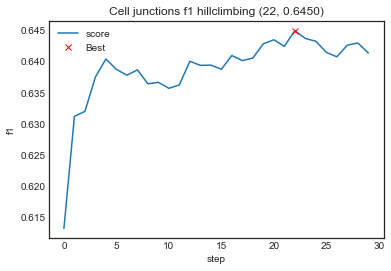

    step  midx     score          mod      f1_0
0      0    16  0.613174   resnet_u56  0.613174
1      1    14  0.631183   resnet_u25  0.589217
2      2    17  0.631985  resnet_u101  0.609238
3      3    10  0.637516      iv3_q12  0.572149
4      4    16  0.640413   resnet_u56  0.613174
5      5    17  0.638743  resnet_u101  0.609238
6      6    13  0.637810   resnet_q27  0.592097
7      7    14  0.638666   resnet_u25  0.589217
8      8     1  0.636424     irv2_q10  0.544704
9      9    17  0.636660  resnet_u101  0.609238
10    10    10  0.635700      iv3_q12  0.572149
11    11    16  0.636248   resnet_u56  0.613174
12    12    10  0.640052      iv3_q12  0.572149
13    13    16  0.639386   resnet_u56  0.613174
14    14    11  0.639429      iv3_u11  0.556977
15    15    16  0.638764   resnet_u56  0.613174
16    16    17  0.640976  resnet_u101  0.609238
17    17    16  0.640154   resnet_u56  0.613174
18    18    10  0.640565      iv3_q12  0.572149
19    19    17  0.642857  resnet_u101  0

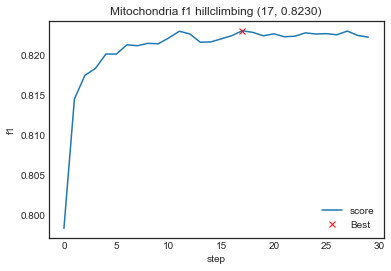

    step  midx     score          mod      f1_0
0      0    16  0.798285   resnet_u56  0.798285
1      1    15  0.814495   resnet_u31  0.783793
2      2    13  0.817458   resnet_q27  0.793827
3      3    11  0.818322      iv3_u11  0.794600
4      4    10  0.820127      iv3_q12  0.785972
5      5    17  0.820124  resnet_u101  0.792117
6      6    13  0.821281   resnet_q27  0.793827
7      7    13  0.821169   resnet_q27  0.793827
8      8    17  0.821466  resnet_u101  0.792117
9      9    15  0.821416   resnet_u31  0.783793
10    10    10  0.822149      iv3_q12  0.785972
11    11    14  0.822983   resnet_u25  0.793940
12    12    11  0.822639      iv3_u11  0.794600
13    13    10  0.821601      iv3_q12  0.785972
14    14    13  0.821644   resnet_q27  0.793827
15    15    15  0.822031   resnet_u31  0.783793
16    16    17  0.822433  resnet_u101  0.792117
17    17    13  0.823044   resnet_q27  0.793827

      weight          mod      f1_0
midx                               
10         3   

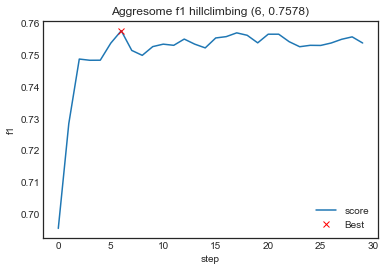

   step  midx     score          mod      f1_0
0     0    16  0.695385   resnet_u56  0.695385
1     1    10  0.728435      iv3_q12  0.657097
2     2    18  0.748830      gap_u14  0.684882
3     3    12  0.748447   resnet_q26  0.616046
4     4    17  0.748466  resnet_u101  0.681351
5     5     6  0.753846      nas_q11  0.577086
6     6     5  0.757764      gap_q12  0.617696

      weight          mod      f1_0
midx                               
5          1      gap_q12  0.617696
6          1      nas_q11  0.577086
10         1      iv3_q12  0.657097
12         1   resnet_q26  0.616046
16         1   resnet_u56  0.695385
17         1  resnet_u101  0.681351
18         1      gap_u14  0.684882


hillclimbing for class 25 Cytosol

model 0 f1 0.6739 iv3_q11
model 1 f1 0.6698 irv2_q10
model 2 f1 0.6734 resnet_q24
model 3 f1 0.6700 resnet_q25
model 4 f1 0.6713 resnet_q40
model 5 f1 0.6662 gap_q12
model 6 f1 0.6439 nas_q11
model 7 f1 0.6476 se_resnext_q26
model 8 f1 0.6677 bni_q0
model 9 f1 0

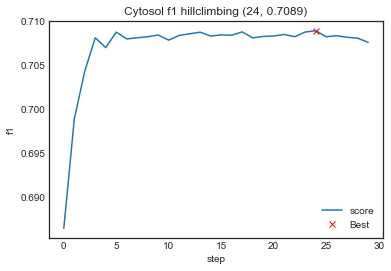

    step  midx     score          mod      f1_0
0      0    13  0.686423   resnet_q27  0.686423
1      1    10  0.698858      iv3_q12  0.684675
2      2    16  0.704314   resnet_u56  0.677617
3      3    15  0.708100   resnet_u31  0.676512
4      4    10  0.706979      iv3_q12  0.684675
5      5    15  0.708738   resnet_u31  0.676512
6      6    13  0.707966   resnet_q27  0.686423
7      7    16  0.708100   resnet_u56  0.677617
8      8    10  0.708217      iv3_q12  0.684675
9      9    15  0.708412   resnet_u31  0.676512
10    10    13  0.707832   resnet_q27  0.686423
11    11    10  0.708362      iv3_q12  0.684675
12    12    17  0.708552  resnet_u101  0.671141
13    13    10  0.708735      iv3_q12  0.684675
14    14    15  0.708293   resnet_u31  0.676512
15    15    13  0.708431   resnet_q27  0.686423
16    16    16  0.708390   resnet_u56  0.677617
17    17    13  0.708770   resnet_q27  0.686423
18    18    17  0.708087  resnet_u101  0.671141
19    19    10  0.708255      iv3_q12  0

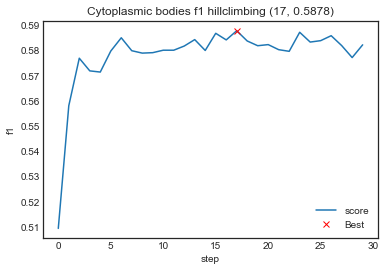

    step  midx     score          mod      f1_0
0      0    16  0.509375   resnet_u56  0.509375
1      1    15  0.558065   resnet_u31  0.493789
2      2    13  0.576923   resnet_q27  0.472180
3      3    12  0.571901   resnet_q26  0.430647
4      4    15  0.571429   resnet_u31  0.493789
5      5    17  0.579760  resnet_u101  0.490818
6      6     9  0.585034       bni_q1  0.421333
7      7    19  0.579901       bni_u1  0.426332
8      8    15  0.578947   resnet_u31  0.493789
9      9     4  0.579125   resnet_q40  0.430345
10    10    19  0.580101       bni_u1  0.426332
11    11    17  0.580101  resnet_u101  0.490818
12    12    15  0.581756   resnet_u31  0.493789
13    13    11  0.584307      iv3_u11  0.416796
14    14    15  0.580000   resnet_u31  0.493789
15    15    17  0.586806  resnet_u101  0.490818
16    16    15  0.584192   resnet_u31  0.493789
17    17    14  0.587826   resnet_u25  0.417303

      weight          mod      f1_0
midx                               
4          1   

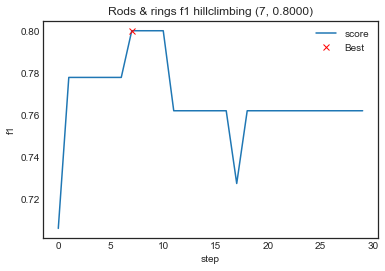

   step  midx     score         mod      f1_0
0     0    16  0.705882  resnet_u56  0.705882
1     1    15  0.777778  resnet_u31  0.666667
2     2    16  0.777778  resnet_u56  0.705882
3     3    15  0.777778  resnet_u31  0.666667
4     4     1  0.777778    irv2_q10  0.555556
5     5    15  0.777778  resnet_u31  0.666667
6     6    15  0.777778  resnet_u31  0.666667
7     7     1  0.800000    irv2_q10  0.555556

      weight         mod      f1_0
midx                              
1          2    irv2_q10  0.555556
15         4  resnet_u31  0.666667
16         2  resnet_u56  0.705882

overall mean f1 0.7477602285098403  mean cut 0.49000000000000005   mean steps 14.571428571428571


<Figure size 432x288 with 0 Axes>

In [265]:
# hillclimbing separately for each class

# vp = oof.copy()
# offset = 5
# nm = vp.shape[1] - offset
nr = vp.shape[0]
y = np.array([y for y in vp.y])
# y = np.array(list(vp['masks'].values))
nstep = 30

step0fix = -1
# step0fix = 5
step1fix = -1

intercept = 0

metric = 'f1'
# metric = 'iou'

# threshold = 0.
# threshold = 0.36
# threshold = 0.5
# print('using ' + metric + ' threshold',threshold)

# metric = "mcc"
# metric = "corr"
# metric = "rmse"
# metric = "mse"
# metric = "mae"
# metric = "winsorized_mae"
# metric = "auc"

cut_mets = ['mcc','f1']
bestCut = threshold

num_classes = 28

rez_all = []
tb_all = []
bestEnsemble_all = []
bestStep_all = []
bestScore_all = []
bestCut_all = []

for c in range(num_classes):
    
    print()
    print()
    print('hillclimbing for class',c,LABEL_MAP[c])
    print()

    rez = pd.DataFrame({'step':np.zeros(nstep).astype(int),'midx':np.zeros(nstep).astype(int),
                        'score':np.zeros(nstep)})
    currEnsemble = 0 * np.array(list(vp.iloc[:,offset].values))

    # maximizing
    bestScore = -9999999
    single = pd.DataFrame({'mod':np.repeat("",nm)})
    start = 0
    for step in range(start,nstep):
        single[metric+'_'+str(step)] = np.nan

    for step in range(start,nstep):
        currIndex = 0
        currScore = -9999999

        for i in range(nm):

            mname = vp.columns[i+offset]

            tv = np.array(list(vp.iloc[:,offset+i].values))

            # mean-center
    #         tv = tv - np.mean(tv)

            # adjust by model-specific threshold
    #         tv = tv - mthresh[mname]

            # adjust by model-class-specific thresholds
    #         for j in range(tv.shape[1]):
    #             tv[:,j] = tv[:,j] - cthresh[mname][j]

            if np.sum(np.isnan(tv)) > 0: continue

            if step==0:
                tryEnsemble = tv
            else:
                # running mean
                tryEnsemble = (step * currEnsemble + tv)/(step+1)
                # full matrix
                # choose median or mean here
                # tryEnsemble = rowMedians(cbind(currEnsemble,tv))
                # tryEnsemble = rowMeans(cbind(currEnsemble,tv))
                # quantiles are a lot slower
                # tryEnsemble = rowQuantiles(cbind(currEnsemble,tv),probs=0.6)

            if metric=="f1":
                # estimate new class-specific thresholds by line search, slow
                cut = fit_val1(tryEnsemble[:,c],y[:,c])
                tryScore = f1_score(y[:,c], np.int32(tryEnsemble[:,c] > cut))

#                 # estimate new class-specific thresholds to match proportions, medium
#                 th = fit_val2(tryEnsemble[:,c],y[:,c])
#                 tryScore = f1_score(y[:,c], np.int32(tryEnsemble[:,c] > th))

#                 # fixed threshold, fast
#                 tryScore = f1_score(y[:,c], np.int32(tryEnsemble[:,c] > threshold))

#                 if step > 0: print('    try',i,mname,"%6.4f" % tryScore)
            elif metric=="iou":
                tryScore = iou_metric_batch(y, np.int32(tryEnsemble > threshold),
                                            pred_eps=pred_eps)
                if step > 0: print('    try',i,mname,"%6.4f" % tryScore)
            elif metric=="mse":
                tryScore = -mse(y,tryEnsemble)
            elif metric=="mae": 
                tryScore = -mae(y,tryEnsemble)
            elif metric=="winsorized_mae": 
                tryScore = -winsorized_mae(y,tryEnsemble+intercept)
            elif metric=="rmse":
                tryScore = -rmse(y,tryEnsemble)
            elif metric=="corr":
                tryScore = cor(y,tryEnsemble)
            elif metric=="mcc":
                opt = eval_mcc3(y,tryEnsemble,cut=T)
                tryScore = opt[1]
                cut = opt[2]
                # opt = optimize(mcc,c(0.1,0.3),tryEnsemble,vp$y,maximum=T)
                # tryScore = opt$objective
            elif metric=="logloss":
                # tryScore = -logLoss(vp$y,tryEnsemble,)
                tryScore = -eval_logloss2(tryEnsemble,y)
            elif metric=="auc":
                tryScore = auc2(y,tryEnsemble)
            elif metric=="auprc":
                tryScore = auprc(tryEnsemble, y)
                # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
                # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.davis.goadrich
            elif metric=="aurocpr":
                auroc = auc(y,tryEnsemble)
                # auprc = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
                tryScore = (auroc + auprc)/2
            elif metric=="sqwk":
                tryScore = sqwk(y,tryEnsemble,1,8)

            ok = 1
            if (step==0) and (step0fix>-1) and (i!=step0fix): ok = 0 
            if (step==1) and (step1fix>-1) and (i!=step1fix): ok = 0 

            if (tryScore > currScore) and (ok==1):
                currIndex = i
                currScore = tryScore
                if (step==0):
                    saveEnsemble = tv.copy()
                else:
                    # running mean
                    saveEnsemble = tryEnsemble.copy()
                    # save whole matrix
                    # saveEnsemble = np.concatenate((currEnsemble,tv),axis=1)
                if metric in cut_mets: currCut = cut

            # if (step==0) or ((step==1) and (step0fix>-1)) or ((step==2) and (step1fix>-1)):
            if (step==0):
                if metric in cut_mets:
                    print("model",i,metric,"%6.4f" % tryScore,
                          "cut %6.4f" % cut, vp.columns[i+offset])
                else:
                    print("model",i,metric,"%6.4f" % tryScore, vp.columns[i+offset])

            if step==0:
                single.loc[i,'mod'] = vp.columns[i+offset]  
            single.iloc[i,step+1] = tryScore

        if metric in cut_mets:
            print("step =", step,"  ", metric,"= %6.4f" % currScore,
                  "  cut = %6.4f" % currCut,"  name =", vp.columns[currIndex+offset])
        else:
            print("step =",step,"  ", metric,"= %6.4f" % currScore,
                  "  name =", vp.columns[currIndex+offset])

        currEnsemble = saveEnsemble.copy()
        if currScore > bestScore:
            bestScore = currScore
            bestStep = step
            bestEnsemble = currEnsemble.copy()
            if metric in cut_mets: bestCut = currCut

        rez.iloc[step,0] = step
        rez.iloc[step,1] = currIndex
        rez.iloc[step,2] = currScore

    if metric in cut_mets:
        print("best step =",bestStep,"  best",metric,"= %6.4f" % bestScore,
              "  best cut = %6.4f" % bestCut)
    else:
        print("best step =",bestStep,"  best",metric,"= %6.4f" % bestScore)

    rez0 = rez.copy()

    # tb = table(rez$index[1:bestStep])
    # names(tb) = names(vp)[(offset+1):ncol(vp)][as.integer(names(table(rez$index[1:bestStep])))]

    # if (intercept!=0) {
    #   tb["Intercept"] = intercept
    # }

    # print(tb[order(-tb)])
    # print(single[order(-single[,2]),][1:min(nrow(single),40),])

    # plot hillclimbing
    print('')
    plt.plot(rez0.step, rez0.score)
    plt.plot(bestStep, bestScore, "xr", label="Best")
    plt.xlabel("step")
    plt.ylabel(metric)
    plt.title(LABEL_MAP[c] + " " + metric + " hillclimbing (%d, %6.4f)" % (bestStep, bestScore))
    plt.legend()
    plt.show()
    plt.gcf().clear()

    # display the weights
    rez = rez.iloc[:(bestStep+1)]
    # print(rez)

    single0 = single.iloc[:,:2]

    rez['midx'] = rez['midx'].astype(int)
    rez = rez.join(single0,how='left',on='midx')
    print(rez)
    print('')

    rez['weight'] = 1
    tb = rez.loc[:,['midx','weight']].groupby('midx').count()
    # print(tb)
    # print(single)

    tb = tb.join(single0,how='left')
    print(tb)
    
    rez_all.append(rez)
    tb_all.append(tb)
    bestEnsemble_all.append(bestEnsemble)
    bestStep_all.append(bestStep)
    bestScore_all.append(bestScore)
    bestCut_all.append(bestCut)

print()
print('overall mean f1',np.mean(bestScore_all),' mean cut',np.mean(bestCut_all),
      '  mean steps',np.mean(bestStep_all))

In [266]:
print('mean f1',np.mean(bestScore_all),' mean cut',np.mean(bestCut_all),
      '  mean steps',np.mean(bestStep_all))

mean f1 0.7477602285098403  mean cut 0.49000000000000005   mean steps 14.571428571428571


In [267]:
# tb_all

In [268]:
midx = str(midx)
fname = 'ens_weights'+midx+'.pkl'
pickle.dump(tb_all,open(fname,'wb'))
print(fname)

ens_weights53.pkl


In [269]:
for i in range(28):
    tb_all[i]['class'] = i
tba = pd.concat(tb_all).reset_index()
print(tba.shape)

(189, 5)


In [270]:
tba.head()

midx  weight          mod      f1_0  class
0     0       1      iv3_q11  0.823961      0
1    13       3   resnet_q27  0.821979      0
2    15       2   resnet_u31  0.798709      0
3    16       1   resnet_u56  0.825270      0
4    17       1  resnet_u101  0.823031      0

In [271]:
# show most popular models
tbag = tba.groupby('mod')
ws = pd.DataFrame(tbag['weight'].sum())
ws.columns = ['ws']
ws.sort_values(['ws'],ascending=False,inplace=True)
print(ws)

                ws
mod               
resnet_u31      74
resnet_u56      71
resnet_q27      66
resnet_u101     62
iv3_q12         43
resnet_u25      18
iv3_u11         15
resnet_q24      14
irv2_q10        13
resnet_q26      12
bni_u1           8
gap_u14          8
iv3_q11          7
nas_q11          6
resnet_q25       6
bni_q0           4
resnet_q40       3
bni_q1           3
gap_q12          2
se_resnext_q26   1


In [272]:
bestCut_all

[0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49,
 0.49]

In [273]:
f1_score(y[:,9],y[:,10])

0.7671232876712328

In [274]:
confusion_matrix(y[:,9],y[:,10])

array([[31027,     0],
       [   17,    28]])

In [275]:
########  OLD CODE BELOW HERE ###########

# best possible score
np.mean(np.max(ioua,axis=0))

NameError: name 'ioua' is not defined

In [ ]:
am = (am + am2) // 2
print(am.shape)
print(am[:50])

In [ ]:
train_df['best_thresh'] = [thresholds[a] for a in am]
train_df['pred_mean'] = [np.mean(b) for b in bestEnsemble]
train_df['pred_std'] = [np.std(b) for b in bestEnsemble]
train_df['pred_min'] = [np.min(b) for b in bestEnsemble]
train_df['pred_max'] = [np.max(b) for b in bestEnsemble]
train_df['image_mean'] = [np.mean(b) for b in train_df.images]
train_df['image_std'] = [np.std(b) for b in train_df.images]
print(train_df.shape)

In [ ]:
fname = 'best_thresh.csv'
train_df.to_csv(fname)
print(fname)

In [ ]:
# predict best threshold with bootstrap forest in jmp
btp = pd.read_csv('btp.csv')
# btp = pd.read_csv('btp2.csv')
print(btp.head())
print(btp.shape)

In [ ]:
btpa = btp.btp.values

In [ ]:
ioub = np.array([iou_metric(m, np.int32(b > (t + 0.1)), pred_eps=pred_eps) \
                 for m, b, t in zip(train_df.masks, bestEnsemble, btpa)])

print(np.mean(ioub))

In [ ]:
# threshold_best_index = np.argmax(ious[9:-10]) + 9
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
print('')
print('iou_best',iou_best)
print('threshold_best',threshold_best)
print('')

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()
plt.show()
plt.gcf().clear()

In [ ]:
# compute best epsilon threshold for computed ensemble, still on logit scale
peps = np.array([1e-12, 0.00001, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01])
ious = np.array([iou_metric_batch(train_df.masks, np.int32(bestEnsemble > threshold_best),
                                  pred_eps=e) for e in peps])

# threshold_best_index = np.argmax(ious[9:-10]) + 9
eps_best_index = np.argmax(ious)
iou_best = ious[eps_best_index]
eps_best = peps[eps_best_index]
print('')
print('iou_best',iou_best)
print('eps_best',eps_best)
print('')

plt.plot(peps, ious)
plt.plot(eps_best, iou_best, "xr", label="Best epsilon")
plt.xlabel("Epsilon")
plt.ylabel("IoU")
plt.title("IOU vs Prediction Epsilon ({}, {})".format(iou_best, eps_best))
plt.legend()
plt.show()
plt.gcf().clear()

In [ ]:
ious

In [ ]:
v = [(np.mean(mask),np.mean(pred)) for mask,pred in zip(train_df.masks,
        np.int32(bestEnsemble > threshold_best))]

In [ ]:
v0 = [(a,b) for a,b in v if a == 0.0 and b > 0.5]

In [ ]:
v0

In [ ]:
v[:20]

In [ ]:
# Error analysis
ioum, ioub = iou_metric_batch(train_df.masks, np.int32(bestEnsemble > threshold_best), \
                              pred_eps=eps_best, return_all=True)
ioub = np.array(ioub)
print(ioub.min(),ioub.mean(),ioub.max())

sns.distplot(ioub)
plt.title("Distribution of OOF IOU Scores")
plt.show()
plt.gcf().clear()

train_df['ens'] = [bestEnsemble[i] for i in range(poof.shape[0])]

train_df['ensb'] = [np.array(bestEnsemble[i] > threshold_best) for i in range(poof.shape[0])]

train_df['pcov'] = [np.array(bestEnsemble[i] > threshold_best).mean() for i in range(poof.shape[0])]

train_df['ioub'] = ioub
print(train_df.columns)
print(train_df.shape)

ct = train_df.loc[:,['z','coverage','coverage_class','ioub']]
print(ct.groupby('coverage_class').mean())
print(ct.groupby('ioub').mean())

# plot coverage
print('')
plt.plot(train_df.pcov, train_df.coverage, 'ro')
plt.xlabel("Predicted Salt Coverage")
plt.ylabel("Observed Salt Coverage")
plt.title("Observed vs Predicted Salt Coverage")
plt.show()
plt.gcf().clear()

print('')
# plt.plot(train_df.pcov, train_df.ioub, 'ro')
sns.regplot(train_df.pcov, train_df.ioub, lowess=True)
plt.xlabel("Predicted Salt Coverage")
plt.ylabel("IOU")
plt.title("IOU vs Predicted Salt Coverage")
plt.show()
plt.gcf().clear()

print('corr',train_df.loc[:,['ioub','coverage','pcov']].corr())

# plot validation images with scores
# sort from worst to best then by salt coverage
train_dfs = train_df.sort_values(['ioub','coverage','pcov'],ascending=[True,True,False])

start = 0
stop = 500
# grid_width = 10
# grid_height = int(max_images / grid_width)
# print(max_images,grid_height,grid_width)
ni = 10

# show worst fitting images
for j in range(int(start/10),int(stop/10)):
    jj = j*10
    fig, axs = plt.subplots(2, ni, figsize=(20,4))
    for i in range(ni):
        img = train_dfs.iloc[jj+i].images
        mask = train_dfs.iloc[jj+i].masks
        pred = train_dfs.iloc[jj+i].ensb
        iou = train_dfs.iloc[jj+i].ioub
        cov = train_dfs.iloc[jj+i].coverage
        pcov = train_dfs.iloc[jj+i].pcov
        axs[0][i].imshow(img, cmap="Greys")
        axs[1][i].imshow(img, cmap="Greys")
        axs[1][i].imshow(mask, alpha=0.3, cmap="Greens")
        axs[1][i].imshow(pred, alpha=0.3, cmap="OrRd")
        axs[0][i].set_title(str(iou) + ' ' + str(np.round(cov,4)) + ' ' + str(np.round(pcov,4)))
    fig.suptitle("Top row: original, bottom row: true salt green, predicted red")
    plt.show()
    plt.gcf().clear()

In [ ]:
print('')
sns.regplot(train_df.pcov, train_df.ioub, lowess=True)
plt.xlabel("Predicted Salt Coverage")
plt.ylabel("IOU")
plt.title("IOU vs Predicted Salt Coverage")
plt.show()
plt.gcf().clear()

In [ ]:
# offset = 3
# nm = oof.shape[1] - offset
# print(offset, oof.shape, nm)

# oof.head()

# np.array(list(oof.iloc[:,3])).shape

# # simple mean ensemble over all models
# first = True
# for i in range(offset,offset+nm):
#     print(i)
#     p = np.array(list(oof.iloc[:,i].values))/nm
#     if first: 
#         ens = p
#         first = False
#     else: ens += p
# print(ens.shape)

# sns.distplot(ens.flatten())
# plt.show()
# plt.gcf().clear()

In [ ]:
d3 = train_df.loc[:,['ioub','coverage','pcov']]
# print(d3.shape)
d3q = d3.query('(coverage == 0.0) & (pcov >= 1e-6)')
print(d3q.shape)
print(d3q.describe())
print(d3q)

In [ ]:
# print(d3.shape)
d0 = d3.query('(ioub == 0.0)')
print(d0.describe())
print(d0.shape)
# print(d0)

In [ ]:
# IOU = 0 values
print('')
plt.plot(d0.pcov, d0.coverage, 'ro')
plt.xlabel("Predicted Salt Coverage")
plt.ylabel("Observed Salt Coverage")
plt.title("IOU = 0, Observed vs Predicted Salt Coverage")
plt.show()
plt.gcf().clear()


In [ ]:
ens = np.int32(bestEnsemble > threshold_best)
iou_metric_batch(train_df.masks, ens, pred_eps=eps_best)

In [ ]:
# average pixel accuracy
ens_cut = []
for e in ens:
    cov = np.mean(e)
    if cov <= pred_eps: e *= 0
    ens_cut.append(e)
    
acc = [np.mean(gt == e) for (gt,e) in zip(train_df.masks,ens_cut)]
print(np.mean(acc))

In [ ]:
# binary cross entropy
from scipy.special import expit
ce = [-np.mean((gt < 0.5)*np.log(1.0 - expit(e)) + (gt > 0.5)*np.log(expit(e))) \
      for (gt,e) in zip(train_df.masks,bestEnsemble)]
print(np.mean(ce))

In [ ]:
np.sum(bestEnsemble > 10.)

In [ ]:
# show max logits for each model, jackie becomes inf with eps <= 1e-4, np.clip does not work on upper bound
scols = ['z','coverage','coverage_class','fold']
mcols = [c for c in oof if c not in scols]
for c in mcols:
    print(c,np.array([m.max() for m in oof[c]]).max())

In [ ]:
i = 0
j = 0
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
# Visualizing the predicted outputs
while True:
    # if str(df.loc[i,'rle_mask'])!=str(np.nan):        
    if True:        
        # decoded_mask = rle_decode(df.loc[i,'rle_mask'])
        plt.subplot(1,6,j+1)
        # plt.imshow(decoded_mask)
        plt.imshow(ens[i])
        plt.title('ID: '+train_df.index.values[i])
        j = j + 1
        if j>5:
            break
    i = i + 1

In [ ]:
# crf kaggle kernel
def crf(original_image, mask_img):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)

#     # Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    
#     # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    # Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    # Run Inference for 10 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [ ]:
ens_crf = []
for i in range(train_df.shape[0]):
    ens_crf.append(crf(train_df.masks[i],ens[i]))
    if i % 1000 == 0: print(i)
ens_crf = np.array(ens_crf)  

In [ ]:
iou_metric_batch(train_df.masks,ens_crf,pred_eps=eps_best)

In [ ]:
print(tb)

In [ ]:
oof.shape

In [ ]:
oof.columns

In [ ]:
folds = pd.read_csv('folds.csv')
print(folds.head())
print(folds.shape)

In [ ]:
oof = oof.join(folds.set_index('id'),how='left')
print(oof.columns)

In [ ]:
scols = ['z','coverage','coverage_class','fold']
mcols = [c for c in oof if c not in scols]
print(oof.loc[:,scols].describe())

In [ ]:
d = 101
s = oof.loc[:,scols]
ss = pd.concat([s]*(d*d))
print(ss.head())
print(ss.shape)

m = np.array(oof.loc[:,mcols])
print(m.shape)

In [ ]:
# pull out 10 x 10 central crop as a small test case
small = oof.copy()
for c in mcols:
    # small[c] = [cc[45:55,45:55] for cc in small[c]]
    small[c] = [cc[5:100:10,5:100:10] for cc in small[c]]
print(small.shape)

In [ ]:
d = 10
s = small.loc[:,scols]
ss = pd.concat([s]*(d*d))
print(ss.head())
print(ss.shape)

m = np.array(small.loc[:,mcols])
print(m.shape)

In [ ]:
m = np.array([np.array(list(i)) for i in m])
print(m.shape)

In [ ]:
m = m.transpose((2,3,0,1))
print(m.shape)

In [ ]:
m = m.reshape((-1,m.shape[-1]))
print(m.shape)

In [ ]:
md = pd.DataFrame(m)
md.columns = mcols
print(md.shape)

In [ ]:
sr = ss.reset_index()
f = pd.concat((sr,md),axis=1)
print(f.shape)

In [ ]:
print(f.columns)

In [ ]:
print(f['id'].head())

In [ ]:
print(f.loc[:,['z','coverage','coverage_class','fold','images','masks','si0c20']].describe())

In [ ]:
# fname = 'small_stack0.csv'
# fname = 'small_stack1.csv'
# fname = 'small_stack2.csv'
fname = 'small_stack3.csv'
f.to_csv(fname)
print(fname)

In [ ]:
ldf.head()

In [ ]:
logit[:4]

In [ ]:
ldf.drop('logit_xception_o0',inplace=True,axis=1)

m = 'xception_o0'
for j in range(3):
    ldf[m+'_logit_'+str(j)] = [a for a in logit[:,j]]

ldf.head()

ldf.set_index('id',inplace=True)

train_df = train_df.join(ldf)

In [ ]:
train_df.columns